# Geodatenanalyse 2 - Termin Machine Learning 3 (ANN, MLP)
## ANN - Multilayer Perceptron
### Import von benötigten Paketen


In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Pre-processing
Wir verwenden für diesen Teil wieder die Grundwasserqualitätsdaten, die wir bereits beim vorigen Termin für die Binär-Klassifikation verwendet haben. Ziel ist es, mit Hilfe der anderen Parameter jeweils die Landnutzung (d.h. landwirtschaftlich ja/nein) in Form einer Binär-Klassifikation sowie die Nitrat-Gehalte in Form einer Regression vorherzusagen.

Die Daten sind bereits teilweise pre-processed (kategorische Variablen sind encodiert, Werte unter der NWG wurden ersetzt). Wir prüfen nun noch, ob Nan-Werte vorhanden sind, löschen diesen, und löschen anschließend noch nicht benötigte Spalten.

In [2]:
# Einladen der Daten
filename = 'gwdata_2005.csv'
dataset = pd.read_csv(filename, delimiter=';', encoding='latin1')

# Prüfen auf Nan-Werte
dataset.isnull().sum()


GWNum           0
Messstelle      0
Ca              0
Cl              0
DOC             0
LF_mS_m         0
K               0
Mg              0
Na              0
NO3             0
pH             50
SO4             0
SiO2            0
U               0
PSM             0
Rechtswert      0
Hochwert        0
Aquifer_kz      0
Aquifer         6
Aquifer2        0
landuse         0
landuse_num     0
dtype: int64

In [3]:
# Löschen von Zeilen mit Nan-Werten und nicht benötigter Spalten

dataset_cleaned = dataset.dropna()

mydata = dataset_cleaned.drop(['GWNum','Messstelle','Rechtswert', 'Hochwert', 'Aquifer','Aquifer2','landuse'], axis=1)
mydata.head()

,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,NO3,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,12.4,6.92,15.6,8.9,0.00025,0.0,31,0
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,4.5,6.78,2.0,10.7,0.00025,0.0,81,0
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,4.0,6.69,4.0,16.0,0.00025,0.0,91,0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.4,6.96,3.4,18.6,0.00025,0.0,91,0
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,18.2,7.25,23.1,12.3,0.00025,0.0,4,0


## Klassifikation
### Splitten der Daten

Das Aufteilen des Datensatzes erfolgt mit der Funktion ["train_test_split"](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split) des Packages sklearn.

Hier kann mit dem Parameter "test_size" das Verhältnis festgelegt werden und mit dem Parameter "random_state" die Reproduzierbarkeit garantiert werden. Der Testdatensatz dient später dazu, zu evaluieren, wie gut das trainierte neuronale Netz generalisieren kann, d.h. Daten vorhersagen, die es vorher "noch nie gesehen hat".

Um Overfitting zu vermeiden und/oder das ANN hinsichtlich sog. Hyperparameter zu optimieren müssen wir die vorhandenen Daten weiter in einzelne Datensätze aufteilen. Je nach Zusammenhang bzw. Verwendung werden diese als Stopp-Set, Optimierungs-Set oder als Validation-Set bezeichnet. Diese können ebenfalls mit der Funktion train_test_split erzeugt werden.

Für den Anfang wollen wir lediglich einen weiteren Datensatz, um Overfitting zu vermeiden. Diesen bezeichnen wir mit val für validation. Er wird später bei jedem Trainingsschritt parallel beobachtet. Das ursprüngliche Training-Set (zunächst als temp bezeichnet) teilen wir dazu erneut auf:

In [4]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

temp, test = train_test_split(mydata, test_size=0.2, random_state=27)

train, val = train_test_split(temp, test_size=0.1, random_state=27)

print('Größe Trainings-Set: ', train.shape)
print('Größe Validation-Set: ', val.shape)
print('Größe Test-Set: ', test.shape)

Größe Trainings-Set:  (1352, 15)
Größe Validation-Set:  (151, 15)
Größe Test-Set:  (376, 15)


### Skalieren

Für neuronale Netze müssen die Eingangsdaten skaliert werden. Je nach Datensatz und Fragestellung kann man die Daten entweder Normieren oder Standardisieren. Wir wählen hier die Normierung, damit unsere landuse_num Kategorien erhalten bleiben.

Der Scaler wird zunächst an die Daten des Trainings-Set gefittet. Anschließend werden sowohl Trainings-Set,  Validation-Set und Test-Set transformiert.

In [5]:
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### Aufteilen der Daten in Input- und Zieldaten

In [6]:
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_val = val[:, :-1] # for all but last column --> Input variables
y_val = val[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable

### Aufbau und Training des ANN

Wir importieren zunächst weitere nötige Pakete, und lesen dann die Anzahl der Input-features aus. Anschließend erstellen wir ein einfaches ANN mit einer Eingabeschicht (deren Neuronen-Zahl automatisch auf Basis der Anzahl der Input-Features erzeugt wird), einer verdeckten Schicht mit 5 Neuronen und einer Ausgabeschicht mit einem Neuron für unseren Zielwert (Landnutzung). Vollständig miteinerander verbundene Schichten (fully connected layers) werden in Keras als Dense-Layer bezeichnet. MLPs fallen unter die Kategorie der sog. sequentiellen Modelle (in denen die Schichten quasi nacheinander abgearbeitet werden). Näheres zur Erstellung sequentieller Modelle in Tensorflow-Keras findet sich [hier](https://www.tensorflow.org/guide/keras/sequential_model).

Weitere Hyperparameter des Modells (neben der Anzahl der Schichten und Neuronen) sind die [Initialisierungsfunktion](https://www.tensorflow.org/api_docs/python/tf/keras/initializers), die [Aktivierungsfunktion](https://www.tensorflow.org/api_docs/python/tf/keras/activations), der [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) und die [Batch-Size](https://www.tensorflow.org/guide/keras/training_with_built_in_methods) (Anzahl der Inputs, die dem Netz pro Epoche auf einmal präsentiert werden). Die Batch-Size wird während des Trainings mit der Funktion model.fit als Parameter angegeben, die Initialisierungs- und Aktivierungsfunktionen bei der Modell-Definition für jede Schicht, und der Optimizer als Parameter beim Kompilieren des Modells mit der Funktion model.compile.

Die Hyperparamter werden zunächst relativ wahllos gewählt. Als Aktivierungsfunktion verwenden wir "ReLu" für die verdeckte Schicht, was für die meisten Problem in der Regel gut funktioniert. Für die Ausgabeschicht verwenden wir eine sigmoidale Aktivierungsfunktion, um sicherzustellen, dass die Ausgabe des Netzwerks zwischen 0 und 1 liegt und sich leicht auf eine der beiden Klassen mit einem Standard-Schwellenwert von 0,5 abbilden lässt. Der Adam-Optimizer gilt ebenfalls für viele Probleme als Methode der Wahl. Bei der Batch-Size findet man häufig Anfangswerte von 16, 32 oder 64. Alle Hyperparameter können später noch optimiert werden. Als loss-Funktion kommt für die binäre Klassifikation "binary_crossentropy" zum Einsatz, als Metrik die "accuracy". Zunächst starten wir mit 50 Epochen.

Nach dem eigentlichen Training (model.fit) führen wir mit model.evaluate eine Vorhersage mit den validation-Inputs aus, um einen Hinweis dafür zu bekommen, wie gut das Modell ist.

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6128 - loss: 0.6794 - val_accuracy: 0.6954 - val_loss: 0.6563
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6731 - val_accuracy: 0.6821 - val_loss: 0.6479
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6700 - val_accuracy: 0.6821 - val_loss: 0.6429
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6681 - val_accuracy: 0.6821 - val_loss: 0.6397
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6665 - val_accuracy: 0.6821 - val_loss: 0.6373
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6085 - loss: 0.6646 - val_accuracy: 0.6821 - val_loss: 0.6350
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6098 - loss: 0.6627 - val_accuracy: 0.6821 - val_loss: 0.6331
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6098 - loss: 0.6608 - val_accuracy: 0.6821 - val_loss:

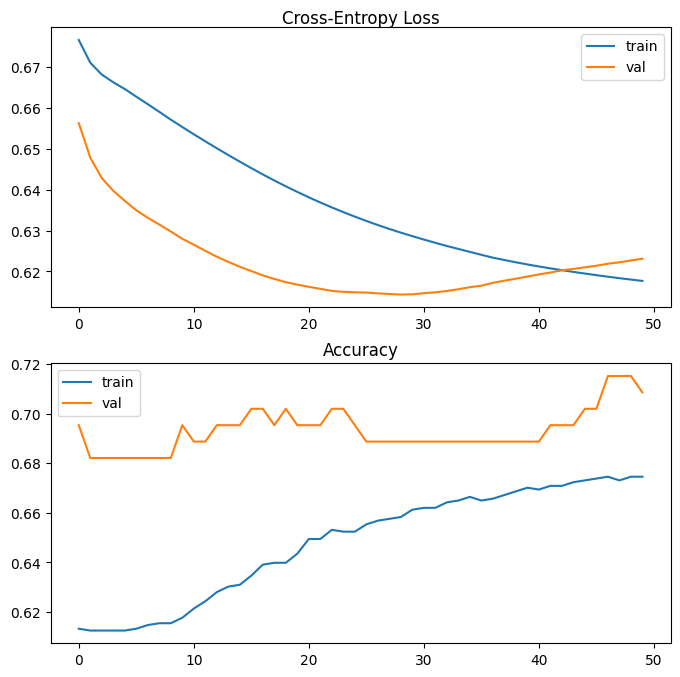

In [7]:
# import packages
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from matplotlib import pyplot

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model to training data, set number of epochs and batch_size
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_val,y_val))

# make class predictions with the model
predictions = (model.predict(X_val) > 0.5).astype("int32")

# compute accuracy
_, accuracy = model.evaluate(X_val,y_val)
print('Accuracy: %.2f' % (accuracy*100))

# plot loss learning curves

pyplot.figure(figsize=(8,8)) 
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

Falls wir sehen, dass ein Overfitting eintritt, können wir die Anzahl der Epochen von Hand anpassen und einen zweiten Durchlauf starten (später mehr zu Techniken, wie man das Training im Fall von Overfitting automatisch stoppen kann).

Die Accuracy beträgt bei diesem sehr einfachen und nicht optimierten Modell für die Validierungsdaten immerhin etwa 66% und ist damit in etwa vergleichbar mit der Performance des SVM/Scaled SVM aus dem vorigen Termin (aber nicht so gut wie Random Forest). Da diese Konfiguration ganz gut zu funktionieren scheint, bauen wir das Modell nochmals neu auf, trainieren es mit dem kompletten Trainingsdatensatz (inklusive der Validierungs-Daten) und sagen damit die Landnutzung unseres Test-Datensatzes voraus. Da im vorigen Versuch ein Overfitting bei etwa 30 Epochen eintrat, wählen wir statt 50 Epochen nun 30. **ACHTUNG: Die absoluten Werte für die Accuracy und die Anzahl der Epochen, bei denen Overfitting auftritt, variieren! Dies hängt vom Split der Daten und der Initialisierung ab!**

In [8]:
seed(1)
tf.random.set_seed(2)

# Split data
train, test = train_test_split(mydata, test_size=0.2, random_state=27)

# Scale data
scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

# Input- and Target-Data
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable


# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()


# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

# make class predictions with the model
predictions = model.predict(X_val)

# compute accuracy
_, accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6161 - loss: 0.6737  
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.6646
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.6612
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.6591
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.6172 - loss: 0.6575
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.6172 - loss: 0.6559
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.6172 - loss: 0.6544
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6172 - loss: 0.6529
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.6513
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.6172 - loss: 0.6496
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.6186 - loss: 0.6479
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accur

Auch dies scheint offensichtlich ähnlich gut zu funktionieren, die Vorhersage-Genauigkeit für den Test-Datensatz beträgt in diesem Durchlauf etwa 66 %. Die eigentlichen Daten können je nach Durchlauf aufgrund der unterschiedlichen Initialisierungen variieren. Wie man das Modell robuster macht, dazu bei der Regression mehr.

## Regression

### Splitten der Daten

Zunächst sortieren wir für die Regression nun die Spalten so um, dass die Spalte mit den Werten, die wir später vorhersagen wollen, in diesem Fall Nitrat, am Ende steht. Das macht uns die Aufteilung in Input- und Zieldaten leichter. Anschließend wiederholen wir die Skalierung und Aufteilung der Daten.

Das Aufteilen des Datensatzes erfolgt mit der Funktion "train_test_split" des Packages sklearn.

Hier kann mit dem Parameter "test_size" das Verhältnis festgelegt werden und mit dem Parameter "random_state" die Reproduzierbarkeit garantiert werden. Der Testdatensatz dient später dazu, zu evaluieren, wie gut das trainierte neuronale Netz generalisieren kann, d.h. Daten vorhersagen, die es vorher "noch nie gesehen hat".

Um Overfitting zu vermeiden und/oder das ANN hinsichtlich sog. Hyperparameter zu optimieren müssen wir die vorhandenen Daten weiter in einzelne Datensätze aufteilen. Je nach Zusammenhang bzw. Verwendung werden diese als Stopp-Set, Optimierungs-Set oder als Validation-Set bezeichnet. Diese können ebenfalls mit der Funktion train_test_split erzeugt werden.

Für den Anfang wollen wir lediglich einen weiteren Datensatz, um Overfitting zu vermeiden. Dieser wird später bei jedem Trainingsschritt parallel beobachtet. Das ursprüngliche Training-Set (zunächst als temp bezeichnet) teilen wir dazu erneut auf.



In [9]:
mydata_reg = mydata[['Ca','Cl','DOC','LF_mS_m','K','Mg','Na','pH','SO4','SiO2','U','PSM','Aquifer_kz','landuse_num','NO3']]
mydata_reg.head()


,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num,NO3
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,6.92,15.6,8.9,0.00025,0.0,31,0,12.4
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,6.78,2.0,10.7,0.00025,0.0,81,0,4.5
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,6.69,4.0,16.0,0.00025,0.0,91,0,4.0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.96,3.4,18.6,0.00025,0.0,91,0,6.4
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,7.25,23.1,12.3,0.00025,0.0,4,0,18.2


In [10]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

train, val = train_test_split(temp, test_size=0.1, random_state=27)

print('Größe Trainings-Set: ', train.shape)
print('Größe Validation-Set: ', val.shape)
print('Größe Test-Set: ', test.shape)

Größe Trainings-Set:  (1352, 15)
Größe Validation-Set:  (151, 15)
Größe Test-Set:  (376, 15)


### Skalieren

Für neuronale Netze müssen die Eingangsdaten skaliert werden. Je nach Datensatz und Fragestellung kann man die Daten entweder Normieren oder Standardisieren. Wir wählen hier die Standardisierung, die für Regressionsproblem gut geeignet ist.

Der Scaler wird zunächst an die Daten des Trainings-Set gefittet. Anschließend werden sowohl Trainings-Set,  Validation-Set und Test-Set transformiert.

In [11]:
scaler = StandardScaler()
scaler.fit(train)

train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### Aufteilen der Daten in Input- und Zieldaten

In [12]:
X_train = train[:, :-1] # for all but last column --> Input variables
y_train = train[:, -1] # for last column --> Target variable

X_val = val[:, :-1] # for all but last column --> Input variables
y_val = val[:, -1] # for last column --> Target variable

X_test = test[:, :-1] # for all but last column --> Input variables
y_test = test[:, -1] # for last column --> Target variable

### Aufbau und Training des ANN

Wir importieren zunächst weitere nötige Pakete und lesen dann die Anzahl der Input-features aus. Anschließend erstellen wir ein einfaches ANN mit einer Eingabeschicht (deren Neuronen-Zahl automatisch auf Basis der Anzahl der Input-Features erzeugt wird), einer verdeckten Schicht mit 5 Neuronen und einer Ausgabeschicht mit einem Neuron für unseren Zielwert (Nitrat).

Weitere Hyperparameter des Modells (neben der Anzahl der Schichten und Neuronen) sind die Initialisierungsfunktion, die Aktivierungsfunktion, der Optimizer und die Batch-Size (Anzahl der Inputs, die dem Netz pro Epoche auf einmal präsentiert werden). Diese werden zunächst relativ wahllos gewählt. Als Aktivierungsfunktion verwenden wir für die verdeckte Schicht "ReLu", was für Regressionsprobleme in der Regel gut funktioniert. **Für die Ausgabeschicht wird im Gegensatz zum Beispiel vorher keine Aktivierungsfunktion verwendet, da es sich um ein Regressionsproblem handelt und wir daran interessiert sind, numerische Werte direkt ohne Transformation vorherzusagen.**

Der Adam-Optimizer gilt ebenfalls für viele Probleme als Methode der Wahl. Bei der Batch-Size findet man häufig Anfangswerte von 16, 32 oder 64. Alle Hyperparameter können später noch optimiert werden.

Als loss-Funktion kommt für die Regression der mean squared error zum Einsatz. Die Anzahl der Epochen erhöhen wir zunächst auf 100, da eine Regression ein komplexeres Problem darstellt, das evtl. mehr Training benötigt.

Nach dem eigentlichen Training (model.fit) führen wir eine Vorhersage mit den validation-Inputs aus, um einen Hinweis dafür zu bekommen, wie gut das Modell ist. Dazu vergleichen wir die Vorhersage mit den bekannten Zielwerten und berechnen den MSE.

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5862 - val_loss: 1.4417
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3653 - val_loss: 1.3639
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2332 - val_loss: 1.2938
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1441 - val_loss: 1.2383
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0812 - val_loss: 1.1921
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0335 - val_loss: 1.1475
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9971 - val_loss: 1.1181
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9678 - val_loss: 1.0867
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9447 - val_loss: 1.0592
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9252 - val_loss: 1.0340
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9095 - val_loss: 1.0165
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

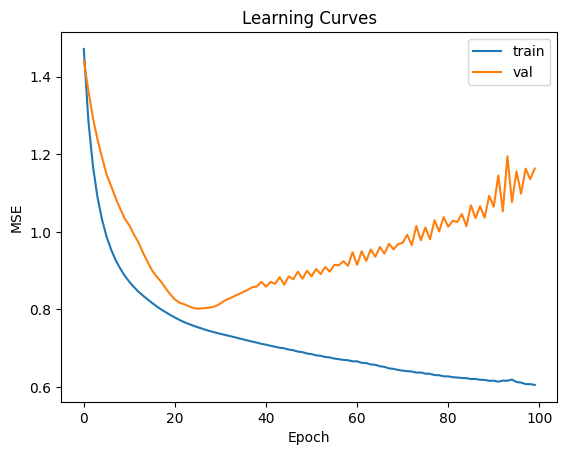

In [13]:
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from matplotlib import pyplot

seed(1)
tf.random.set_seed(2)

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()


# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1))


# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val))

# predict test set
yhat = model.predict(X_val)

# evaluate predictions
score = mean_squared_error(y_val, yhat)
print('MSE: %.3f' % score)

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Wir sehen, dass ab einer bestimmten Anzahl Epochen ein Overfitting eintritt. Da dies aber sehr stark von den tatsächlichen Eingangsdaten sowie der Initialisierung abhängt, ist es besser, keine absolute Zahl festzulegen, sondern die Technik des ["Early Stopping"](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) anzuwenden. Dabei werden nach jeder Epoche die Gewichte abgespeichert und sobald sich der Fehler im Validierungsdatensatz für eine bestimmte Anzahl von Epochen nicht mehr verbessert, bricht das Training ab (Early Stopping) und springt zu den gespeicherten Gewichten des "besten" Durchlaufs zurück.

Im Folgenden der Code von oben mit Early Stopping. Falls man Early Stopping gleich zu Beginn einbaut, empfiehlt es sich, die Anzahl der Epochen etwas höher zu setzen, damit das Early Stopping auch greifen kann. Zudem sollte man die sog. "Patience", d.h. die Anzahl der Epochen, bei der der MSE im Validation Set wieder zunehmen darf, bevor das Training gestopppt wird, nicht zu klein wählen, vor allem bei Modellen, die etwas instabil sind. Da das obige Modell recht stabil ist (keine großen Sprünge im MSE von Epoche zu Epoche), reicht hier eine Patience von 5 aus. Details zu Early Stopping (und anderen sog. "CallBacks" findet sich in der Hilfe zu [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2622 - val_loss: 1.2976
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1567 - val_loss: 1.2119
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0932 - val_loss: 1.1431
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0453 - val_loss: 1.0854
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0070 - val_loss: 1.0359
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9751 - val_loss: 0.9922
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9490 - val_loss: 0.9500
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9273 - val_loss: 0.9149
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9094 - val_loss: 0.8837
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8945 - val_loss: 0.8568
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8824 - val_loss: 0.8339
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

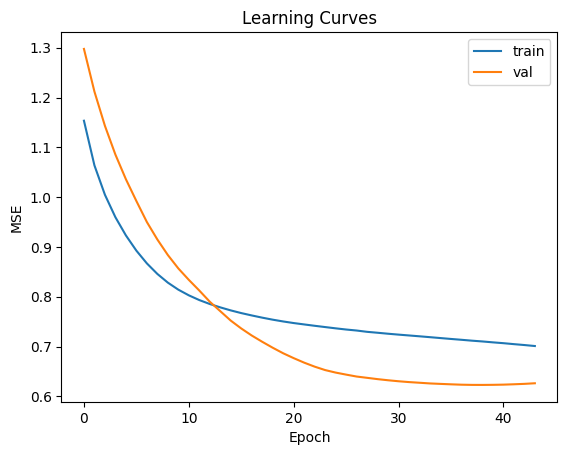

In [15]:
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot

seed(1)
tf.random.set_seed(2)

# determine the number of input features
n_features = X_train.shape[1]

# set initializer
kernel_initializer = initializers.glorot_uniform()

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val),
                    callbacks=[es])

# predict test set
yhat = model.predict(X_val)

# evaluate predictions
score = mean_squared_error(y_val, yhat)
print('MSE: %.3f' % score)

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### Kfold Crossvalidation
Um nun zu testen, wie robust die Vorhersage ist, wiederholen wir das Ganze mit einer [Kfold crossvalidation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold). Diese kenn wir schon vom vorigen Termin. Sie wird vom Paket sklearn zur Verfügung gestellt und kann mit beliebigen ML-Algorithmen kombiniert werden.

Wir verwenden 10 Folds, d.h. wir splitten unsere Daten in jeweils 90% Trainings- und 10% Validierungsdaten. Dafür müssen wir die Reihenfolge des Datensplitting und der Skalierung ggü. oben etwas umstellen. Das Training und die Validation werden anschließend in einer Schleife ausgeführt.

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7216 - val_loss: 4.0603
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8524 - val_loss: 3.2409
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3722 - val_loss: 2.6300
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0503 - val_loss: 2.1929
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8124 - val_loss: 1.8630
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6274 - val_loss: 1.6067
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4834 - val_loss: 1.4174
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3690 - val_loss: 1.2992
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2772 - val_loss: 1.2045
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2024 - val_loss: 1.1272
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1408 - val_loss: 1.0653
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0

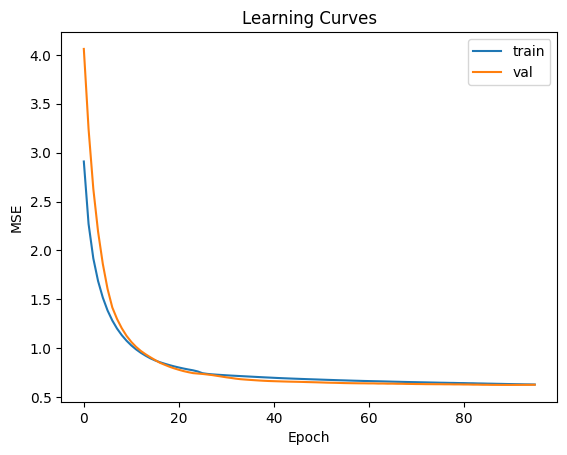

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5139 - val_loss: 1.2487
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2755 - val_loss: 1.1284
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1447 - val_loss: 1.0440
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0505 - val_loss: 0.9803
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9796 - val_loss: 0.9304
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9257 - val_loss: 0.8913
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8839 - val_loss: 0.8615
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8496 - val_loss: 0.8387
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8231 - val_loss: 0.8206
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8036 - val_loss: 0.8055
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7896 - val_loss: 0.7933
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7

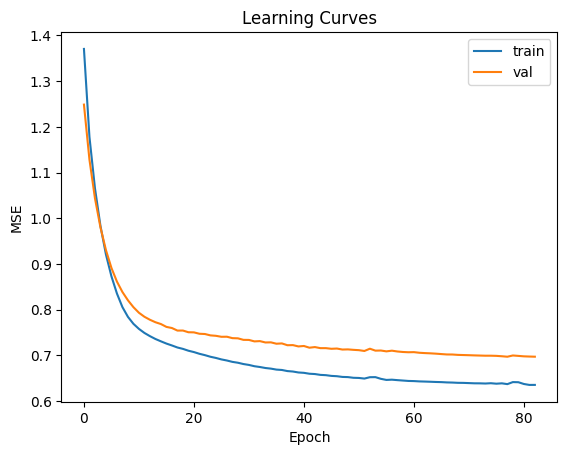

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4952 - val_loss: 3.1616
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3273 - val_loss: 2.7596
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2190 - val_loss: 2.4618
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1385 - val_loss: 2.2454
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0801 - val_loss: 2.0867
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0370 - val_loss: 1.9634
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0052 - val_loss: 1.8679
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9800 - val_loss: 1.7883
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9605 - val_loss: 1.7281
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9445 - val_loss: 1.6305
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9293 - val_loss: 1.5363
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9

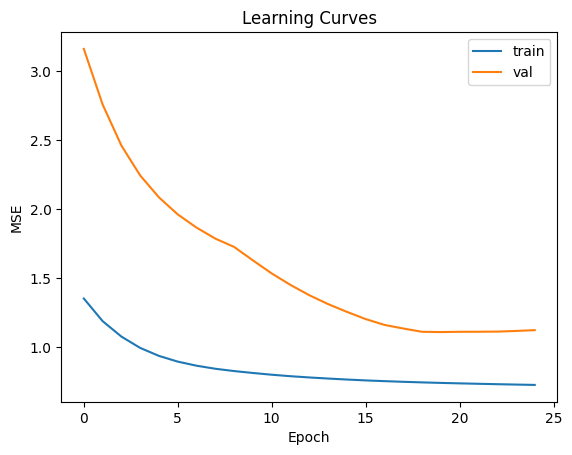

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7739 - val_loss: 1.3897
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4359 - val_loss: 1.2004
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2842 - val_loss: 1.0797
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1816 - val_loss: 1.0033
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1094 - val_loss: 0.9490
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0585 - val_loss: 0.9118
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0184 - val_loss: 0.8842
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9874 - val_loss: 0.8634
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9640 - val_loss: 0.8496
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9477 - val_loss: 0.8373
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9318 - val_loss: 0.8282
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9

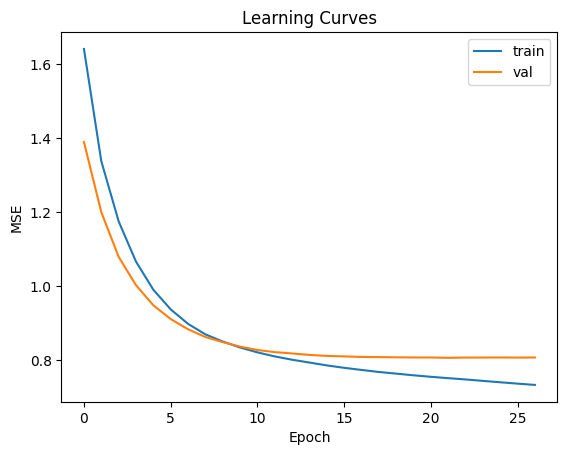

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2268 - val_loss: 2.0313
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8404 - val_loss: 1.8389
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6019 - val_loss: 1.7025
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4326 - val_loss: 1.6041
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3152 - val_loss: 1.5249
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2291 - val_loss: 1.4606
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1628 - val_loss: 1.4066
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1096 - val_loss: 1.3601
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0661 - val_loss: 1.3162
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0255 - val_loss: 1.2792
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9900 - val_loss: 1.2458
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9

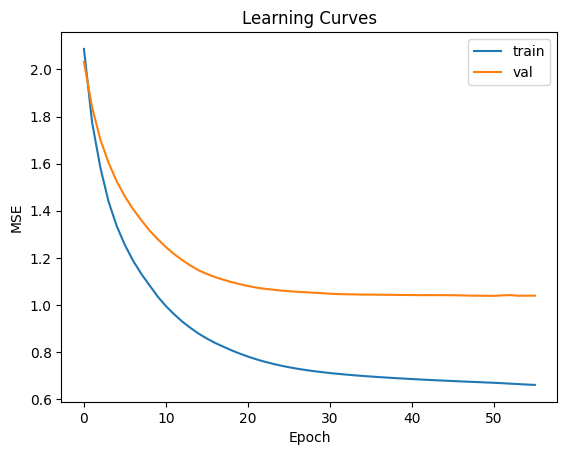

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4418 - val_loss: 1.1054
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3087 - val_loss: 1.0351
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2155 - val_loss: 0.9790
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1348 - val_loss: 0.9284
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0631 - val_loss: 0.8845
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9993 - val_loss: 0.8449
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9442 - val_loss: 0.8119
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8987 - val_loss: 0.7855
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8640 - val_loss: 0.7675
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8383 - val_loss: 0.7551
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8190 - val_loss: 0.7451
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

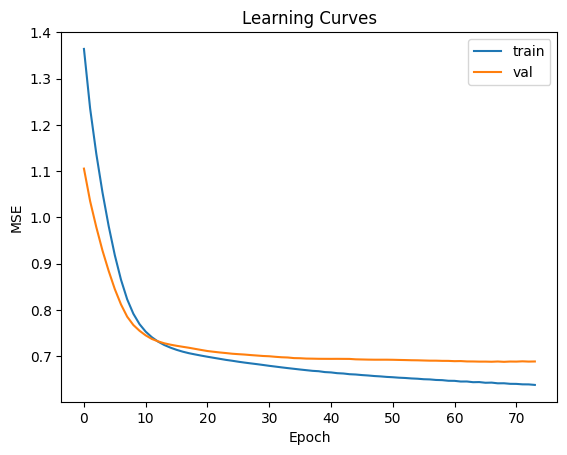

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1615 - val_loss: 0.9759
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0747 - val_loss: 0.8827
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0207 - val_loss: 0.8265
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9812 - val_loss: 0.7937
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9525 - val_loss: 0.7758
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9319 - val_loss: 0.7672
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9152 - val_loss: 0.7627
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9011 - val_loss: 0.7598
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8887 - val_loss: 0.7581
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8768 - val_loss: 0.7558
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8659 - val_loss: 0.7544
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

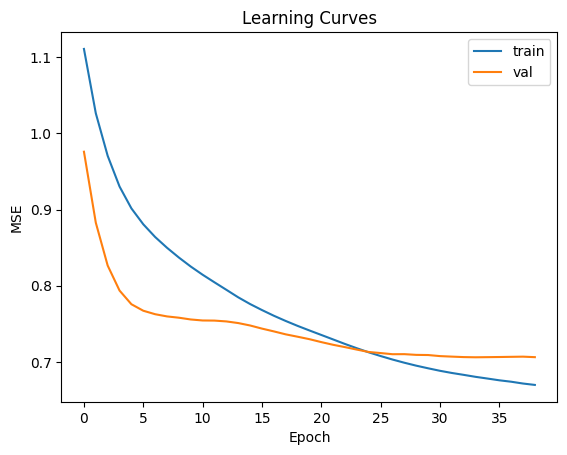

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9915 - val_loss: 1.6496
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4881 - val_loss: 1.4505
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2885 - val_loss: 1.3548
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1722 - val_loss: 1.3004
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0964 - val_loss: 1.2631
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0441 - val_loss: 1.2354
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0049 - val_loss: 1.2126
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9734 - val_loss: 1.1948
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9482 - val_loss: 1.1785
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9277 - val_loss: 1.1621
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9117 - val_loss: 1.1483
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

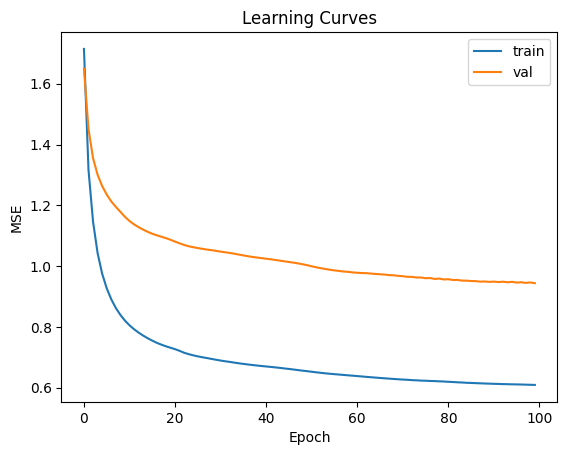

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4541 - val_loss: 1.4119
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7971 - val_loss: 1.1755
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4577 - val_loss: 1.0404
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2534 - val_loss: 0.9596
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1333 - val_loss: 0.9085
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0567 - val_loss: 0.8721
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0037 - val_loss: 0.8452
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9655 - val_loss: 0.8237
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9367 - val_loss: 0.8066
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9137 - val_loss: 0.7917
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8941 - val_loss: 0.7789
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

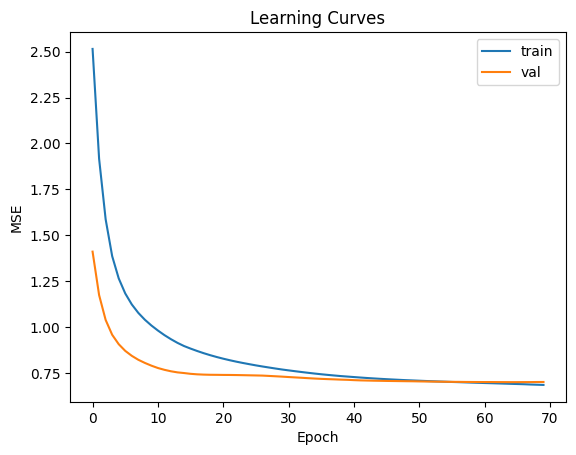

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9028 - val_loss: 1.5872
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5051 - val_loss: 1.3013
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3089 - val_loss: 1.1390
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1954 - val_loss: 1.0221
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1136 - val_loss: 0.9344
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0517 - val_loss: 0.8635
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0022 - val_loss: 0.8071
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9631 - val_loss: 0.7594
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9310 - val_loss: 0.7196
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9040 - val_loss: 0.6861
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8813 - val_loss: 0.6581
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

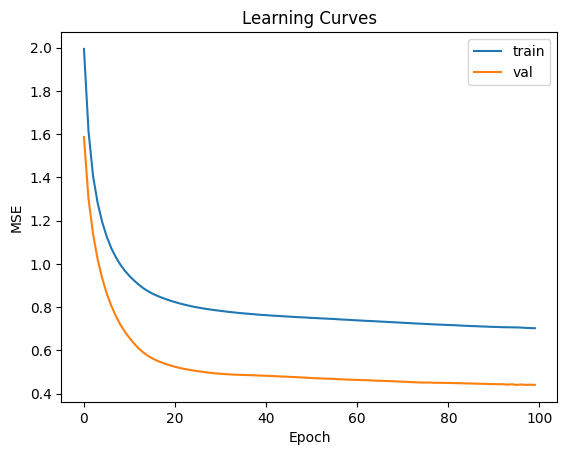

Mean MSE: 0.776 (0.192)


In [16]:
seed(1)
tf.random.set_seed(2)

temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
scaler.fit(temp)

temp = scaler.transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]

X_test, y_test = test[:, :-1], test[:, -1]


# prepare cross validation
from numpy import mean
from numpy import std

kfold = KFold(10, shuffle=True, random_state=27)

# enumerate splits
scores = list()


for train_ix, val_ix in kfold.split(X, y):
    # split data
    X_train, X_val, y_train, y_val = X[train_ix], X[val_ix], y[train_ix], y[val_ix]
    # determine the number of input features
    n_features = X.shape[1]
    # set initializer
    kernel_initializer = initializers.glorot_uniform
    
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    # define model
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val,y_val),
                       callbacks=[es])

    # predict test set
    yhat = model.predict(X_val)
    score = mean_squared_error(y_val, yhat)
    print('MSE: %.3f' % score)
    scores.append(score)
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('MSE')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()


# summarize all scores
print('Mean MSE: %.3f (%.3f)' % (mean(scores), std(scores)))

Wir sehen, dass sich sowohl der Verlauf der Lernkurven als auch die Performance (also der MSE) der einzelnen Durchläufe zum Teil stark unterscheiden kann, was zum Einen von den unterschiedlichen Initialisierungen und zum Anderem von der Aufteilung des Datensatzes abhängt.

Auch bei einer zufälligen Aufteilung kann es sein, dass "zufällig" mehr schwierig vorherzusagende Werte im Validierungsatz landen. Dies sind vor allem Werte, die in der Verteilung der Trainingsdaten seltener vorkommen. Im Beispiel von Nitrat wären das hohe Messwerte. Daher ist es wichtig, mit einer Kfold-Crossvalidation die mittlere Performance zu betrachten.

Dem Problem der Initialisierung begegnet man in der Regel damit, dass man viele Modelle mit unterschiedlichen Initialisierungen rechnet (also ein Ensemble bildet) und dann jeweils die mittlere Vorhersage aller Modelle betrachtet. Dies realisiert man über eine Schleife mit verschiedenen Seeds (in der Regel mindestens 5, meistens 10, je mehr desto robuster das Ergebnis), um die Reproduzierbarkeit zu erhalten. Wir verzichten hier darauf, da für die Übung die Rechenzeit zu lange wäre.

### Optimierung von Hyperparametern (der "einfache" Weg)

Ein einfacher Weg, Hyperparameter wie die Batchsize, Lernregel usw. zu optimieren, ist es, einfach alle möglichen Kombinationen durchzuprobieren. Dies wird als "grid search" bezeichnet. Der Vorteil ist, dass man auf jeden Fall die beste Variante finden wird, der Nachteil ist, dass bei einer größeren Anzahl von zu optimierenden Hyperparametern und deren jeweils mögliche Werte(-bereiche) die Anzahl der möglichen Kombinationen schnell so groß wird, dass eine grid search zeitlich gar nicht mehr möglich ist. Es gibt aber noch weitere, effizientere Methoden, dazu in einer späteren Vorlesung mehr.

Im Folgenden führen wir eine kleine grid search durch, wobei wir zwei weitere Optimizer, drei verschiedene Epochen-Anzahlen und drei verschiedene Batch-Sizes testen (also 27 mögliche Kombinationen). Schon das könnte je nach Rechner ganz schön lange dauern. Falls es zu lange dauert, können wir die Anzahl der zu optimierenden Parameter reduzieren. Wenn es bei Ihnen zu lange dauert, nehmen Sie die Epochen raus und arbeiten stattdessen wie oben mit Early Stopping (was sowieso sinnvoller ist).

Wir verwenden hierzu die Funktion [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) aus dem sklearn-Paket, die genau wie Kfold mit allen möglichen ML-Algorithmen kombiniert werden kann und zusätzlich noch den KerasRegressor aus dem [scikeras-Paket](https://adriangb.com/scikeras/stable/) als Wrapper (geht auch ohne, aber so ist es einfacher).

Zunächst wird dabei ein sog. baseline_model definiert, bei dem dann bei der Optimierung basierend auf einem parameter dictionary ("param_grid") die dort definierten Parameter ausgetauscht werden.


In [17]:
import scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

seed(1)
tf.random.set_seed(2)

# define baseline model

def baseline_model(optimizer='adam'):
   
    # define model
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data
temp, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

scaler = StandardScaler()
scaler.fit(temp)

temp = scaler.transform(temp)
test = scaler.transform(test)

X, y = temp[:, :-1], temp[:, -1]

    
# define estimater
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=16, verbose=1)

# define parameter grid: grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam', 'SGD']
#epochs = [30, 50, 70]
epochs = [30]
batches = [8, 16, 32]

param_grid = dict(optimizer=optimizers,
epochs=epochs,
batch_size=batches)

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 1.5857
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 1.2817
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1513
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.0675
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.0048
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.9550
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.9153
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.8806
Epoch 9/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.8547
Epoch 10/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.8326
Epoch 11/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.8149
Epoch 12/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.8042
Epoch 13/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.7888
Epoch 14/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.7803
Epoch 15/30
151/151 ━━━━━━━━━━━

151/151 [==============================] - 0s 513us/step - loss: 0.7770
Epoch 25/30
151/151 [==============================] - 0s 520us/step - loss: 0.7730
Epoch 26/30
151/151 [==============================] - 0s 513us/step - loss: 0.7715
Epoch 27/30
151/151 [==============================] - 0s 515us/step - loss: 0.7682
Epoch 28/30
151/151 [==============================] - 0s 520us/step - loss: 0.7647
Epoch 29/30
151/151 [==============================] - 0s 520us/step - loss: 0.7620
Epoch 30/30
38/38 [==============================] - 0s 432us/step
Epoch 1/30
151/151 [==============================] - 0s 513us/step - loss: 1.4565
Epoch 2/30
151/151 [==============================] - 0s 513us/step - loss: 1.2608
Epoch 3/30
151/151 [==============================] - 0s 513us/step - loss: 1.1380
Epoch 4/30
151/151 [==============================] - 0s 513us/step - loss: 1.0470
Epoch 5/30
151/151 [==============================] - 0s 513us/step - loss: 0.9748
Epoch 6/30
151/151 [======

151/151 [==============================] - 0s 520us/step - loss: 0.6573
Epoch 31/50
151/151 [==============================] - 0s 513us/step - loss: 0.6541
Epoch 32/50
151/151 [==============================] - 0s 520us/step - loss: 0.6501
Epoch 33/50
151/151 [==============================] - 0s 520us/step - loss: 0.6473
Epoch 34/50
151/151 [==============================] - 0s 547us/step - loss: 0.6436
Epoch 35/50
151/151 [==============================] - 0s 527us/step - loss: 0.6415
Epoch 36/50
151/151 [==============================] - 0s 520us/step - loss: 0.6383
Epoch 37/50
151/151 [==============================] - 0s 513us/step - loss: 0.6355
Epoch 38/50
151/151 [==============================] - 0s 520us/step - loss: 0.6339
Epoch 39/50
151/151 [==============================] - 0s 513us/step - loss: 0.6323
Epoch 40/50
151/151 [==============================] - 0s 513us/step - loss: 0.6325
Epoch 41/50
151/151 [==============================] - 0s 507us/step - loss: 0.6263
Epoc

151/151 [==============================] - 0s 500us/step - loss: 0.7057
Epoch 27/50
151/151 [==============================] - 0s 493us/step - loss: 0.7027
Epoch 28/50
151/151 [==============================] - 0s 507us/step - loss: 0.6983
Epoch 29/50
151/151 [==============================] - 0s 507us/step - loss: 0.6972
Epoch 30/50
151/151 [==============================] - 0s 493us/step - loss: 0.6962
Epoch 31/50
151/151 [==============================] - 0s 493us/step - loss: 0.6956
Epoch 32/50
151/151 [==============================] - 0s 500us/step - loss: 0.6926
Epoch 33/50
151/151 [==============================] - 0s 500us/step - loss: 0.6893
Epoch 34/50
151/151 [==============================] - 0s 513us/step - loss: 0.6872
Epoch 35/50
151/151 [==============================] - 0s 500us/step - loss: 0.6858
Epoch 36/50
151/151 [==============================] - 0s 500us/step - loss: 0.6834
Epoch 37/50
151/151 [==============================] - 0s 500us/step - loss: 0.6847
Epoc

151/151 [==============================] - 0s 507us/step - loss: 0.7431
Epoch 23/50
151/151 [==============================] - 0s 500us/step - loss: 0.7385
Epoch 24/50
151/151 [==============================] - 0s 513us/step - loss: 0.7336
Epoch 25/50
151/151 [==============================] - 0s 510us/step - loss: 0.7282
Epoch 26/50
151/151 [==============================] - 0s 520us/step - loss: 0.7254
Epoch 27/50
151/151 [==============================] - 0s 513us/step - loss: 0.7212
Epoch 28/50
151/151 [==============================] - 0s 513us/step - loss: 0.7166
Epoch 29/50
151/151 [==============================] - 0s 513us/step - loss: 0.7125
Epoch 30/50
151/151 [==============================] - 0s 507us/step - loss: 0.7093
Epoch 31/50
151/151 [==============================] - 0s 520us/step - loss: 0.7055
Epoch 32/50
151/151 [==============================] - 0s 507us/step - loss: 0.7016
Epoch 33/50
151/151 [==============================] - 0s 507us/step - loss: 0.6990
Epoc

151/151 [==============================] - 0s 507us/step - loss: 0.7234
Epoch 19/50
151/151 [==============================] - 0s 520us/step - loss: 0.7186
Epoch 20/50
151/151 [==============================] - 0s 527us/step - loss: 0.7154
Epoch 21/50
151/151 [==============================] - 0s 513us/step - loss: 0.7111
Epoch 22/50
151/151 [==============================] - 0s 520us/step - loss: 0.7094
Epoch 23/50
151/151 [==============================] - 0s 520us/step - loss: 0.7068
Epoch 24/50
151/151 [==============================] - 0s 520us/step - loss: 0.7025
Epoch 25/50
151/151 [==============================] - 0s 520us/step - loss: 0.6995
Epoch 26/50
151/151 [==============================] - 0s 515us/step - loss: 0.6992
Epoch 27/50
151/151 [==============================] - 0s 513us/step - loss: 0.6966
Epoch 28/50
151/151 [==============================] - 0s 520us/step - loss: 0.6931
Epoch 29/50
151/151 [==============================] - 0s 527us/step - loss: 0.6914
Epoc

151/151 [==============================] - 0s 500us/step - loss: 0.7666
Epoch 15/50
151/151 [==============================] - 0s 513us/step - loss: 0.7570
Epoch 16/50
151/151 [==============================] - 0s 507us/step - loss: 0.7531
Epoch 17/50
151/151 [==============================] - 0s 500us/step - loss: 0.7450
Epoch 18/50
151/151 [==============================] - 0s 507us/step - loss: 0.7407
Epoch 19/50
151/151 [==============================] - 0s 500us/step - loss: 0.7349
Epoch 20/50
151/151 [==============================] - 0s 500us/step - loss: 0.7319
Epoch 21/50
151/151 [==============================] - 0s 507us/step - loss: 0.7283
Epoch 22/50
151/151 [==============================] - 0s 505us/step - loss: 0.7255
Epoch 23/50
151/151 [==============================] - 0s 527us/step - loss: 0.7222
Epoch 24/50
151/151 [==============================] - 0s 520us/step - loss: 0.7180
Epoch 25/50
151/151 [==============================] - 0s 507us/step - loss: 0.7166
Epoc

151/151 [==============================] - 0s 507us/step - loss: 0.7750
Epoch 11/50
151/151 [==============================] - 0s 507us/step - loss: 0.7620
Epoch 12/50
151/151 [==============================] - 0s 513us/step - loss: 0.7490
Epoch 13/50
151/151 [==============================] - 0s 520us/step - loss: 0.7384
Epoch 14/50
151/151 [==============================] - 0s 521us/step - loss: 0.7273
Epoch 15/50
151/151 [==============================] - 0s 513us/step - loss: 0.7181
Epoch 16/50
151/151 [==============================] - 0s 528us/step - loss: 0.7069
Epoch 17/50
151/151 [==============================] - 0s 516us/step - loss: 0.6999
Epoch 18/50
151/151 [==============================] - 0s 517us/step - loss: 0.6923
Epoch 19/50
151/151 [==============================] - 0s 527us/step - loss: 0.6867
Epoch 20/50
151/151 [==============================] - 0s 527us/step - loss: 0.6807
Epoch 21/50
151/151 [==============================] - 0s 527us/step - loss: 0.6762
Epoc

151/151 [==============================] - 0s 500us/step - loss: 1.4065
Epoch 7/50
151/151 [==============================] - 0s 493us/step - loss: 1.3046
Epoch 8/50
151/151 [==============================] - 0s 493us/step - loss: 1.2261
Epoch 9/50
151/151 [==============================] - 0s 493us/step - loss: 1.1672
Epoch 10/50
151/151 [==============================] - 0s 500us/step - loss: 1.1223
Epoch 11/50
151/151 [==============================] - 0s 500us/step - loss: 1.0855
Epoch 12/50
151/151 [==============================] - 0s 487us/step - loss: 1.0524
Epoch 13/50
151/151 [==============================] - 0s 493us/step - loss: 1.0269
Epoch 14/50
151/151 [==============================] - 0s 493us/step - loss: 1.0059
Epoch 15/50
151/151 [==============================] - 0s 487us/step - loss: 0.9852
Epoch 16/50
151/151 [==============================] - 0s 493us/step - loss: 0.9675
Epoch 17/50
151/151 [==============================] - 0s 487us/step - loss: 0.9522
Epoch 1

151/151 [==============================] - 0s 520us/step - loss: 1.7197
Epoch 3/50
151/151 [==============================] - 0s 527us/step - loss: 1.4317
Epoch 4/50
151/151 [==============================] - 0s 507us/step - loss: 1.2451
Epoch 5/50
151/151 [==============================] - 0s 520us/step - loss: 1.1145
Epoch 6/50
151/151 [==============================] - 0s 513us/step - loss: 1.0143
Epoch 7/50
151/151 [==============================] - 0s 513us/step - loss: 0.9402
Epoch 8/50
151/151 [==============================] - 0s 520us/step - loss: 0.8838
Epoch 9/50
151/151 [==============================] - 0s 520us/step - loss: 0.8413
Epoch 10/50
151/151 [==============================] - 0s 513us/step - loss: 0.8104
Epoch 11/50
151/151 [==============================] - 0s 507us/step - loss: 0.7848
Epoch 12/50
151/151 [==============================] - 0s 520us/step - loss: 0.7662
Epoch 13/50
151/151 [==============================] - 0s 513us/step - loss: 0.7522
Epoch 14/50

151/151 [==============================] - 0s 520us/step - loss: 0.5982
Epoch 50/70
151/151 [==============================] - 0s 520us/step - loss: 0.5968
Epoch 51/70
151/151 [==============================] - 0s 520us/step - loss: 0.5984
Epoch 52/70
151/151 [==============================] - 0s 507us/step - loss: 0.5955
Epoch 53/70
151/151 [==============================] - 0s 520us/step - loss: 0.5980
Epoch 54/70
151/151 [==============================] - 0s 520us/step - loss: 0.5923
Epoch 55/70
151/151 [==============================] - 0s 513us/step - loss: 0.5909
Epoch 56/70
151/151 [==============================] - 0s 513us/step - loss: 0.5931
Epoch 57/70
151/151 [==============================] - 0s 512us/step - loss: 0.5931
Epoch 58/70
151/151 [==============================] - 0s 513us/step - loss: 0.5978
Epoch 59/70
151/151 [==============================] - 0s 513us/step - loss: 0.5937
Epoch 60/70
151/151 [==============================] - 0s 513us/step - loss: 0.5888
Epoc

151/151 [==============================] - 0s 520us/step - loss: 1.0264
Epoch 6/70
151/151 [==============================] - 0s 520us/step - loss: 0.9840
Epoch 7/70
151/151 [==============================] - 0s 514us/step - loss: 0.9501
Epoch 8/70
151/151 [==============================] - 0s 507us/step - loss: 0.9248
Epoch 9/70
151/151 [==============================] - 0s 513us/step - loss: 0.9041
Epoch 10/70
151/151 [==============================] - 0s 520us/step - loss: 0.8853
Epoch 11/70
151/151 [==============================] - 0s 520us/step - loss: 0.8697
Epoch 12/70
151/151 [==============================] - 0s 527us/step - loss: 0.8547
Epoch 13/70
151/151 [==============================] - 0s 539us/step - loss: 0.8411
Epoch 14/70
151/151 [==============================] - 0s 520us/step - loss: 0.8287
Epoch 15/70
151/151 [==============================] - 0s 527us/step - loss: 0.8180
Epoch 16/70
151/151 [==============================] - 0s 521us/step - loss: 0.8104
Epoch 17

151/151 [==============================] - 0s 527us/step - loss: 0.6890
Epoch 33/70
151/151 [==============================] - 0s 533us/step - loss: 0.6894
Epoch 34/70
151/151 [==============================] - 0s 527us/step - loss: 0.6850
Epoch 35/70
151/151 [==============================] - 0s 527us/step - loss: 0.6829
Epoch 36/70
151/151 [==============================] - 0s 527us/step - loss: 0.6799
Epoch 37/70
151/151 [==============================] - 0s 533us/step - loss: 0.6780
Epoch 38/70
151/151 [==============================] - 0s 520us/step - loss: 0.6784
Epoch 39/70
151/151 [==============================] - 0s 527us/step - loss: 0.6745
Epoch 40/70
151/151 [==============================] - 0s 527us/step - loss: 0.6738
Epoch 41/70
151/151 [==============================] - 0s 527us/step - loss: 0.6722
Epoch 42/70
151/151 [==============================] - 0s 527us/step - loss: 0.6711
Epoch 43/70
151/151 [==============================] - 0s 533us/step - loss: 0.6677
Epoc

151/151 [==============================] - 0s 517us/step - loss: 0.6372
Epoch 60/70
151/151 [==============================] - 0s 513us/step - loss: 0.6355
Epoch 61/70
151/151 [==============================] - 0s 520us/step - loss: 0.6351
Epoch 62/70
151/151 [==============================] - 0s 520us/step - loss: 0.6337
Epoch 63/70
151/151 [==============================] - 0s 520us/step - loss: 0.6324
Epoch 64/70
151/151 [==============================] - 0s 513us/step - loss: 0.6316
Epoch 65/70
151/151 [==============================] - 0s 520us/step - loss: 0.6305
Epoch 66/70
151/151 [==============================] - 0s 513us/step - loss: 0.6303
Epoch 67/70
151/151 [==============================] - 0s 520us/step - loss: 0.6296
Epoch 68/70
151/151 [==============================] - 0s 514us/step - loss: 0.6301
Epoch 69/70
151/151 [==============================] - 0s 533us/step - loss: 0.6298
Epoch 70/70
38/38 [==============================] - 0s 433us/step
Epoch 1/70
151/151 [=

151/151 [==============================] - 0s 520us/step - loss: 0.7512
Epoch 16/70
151/151 [==============================] - 0s 513us/step - loss: 0.7456
Epoch 17/70
151/151 [==============================] - 0s 520us/step - loss: 0.7402
Epoch 18/70
151/151 [==============================] - 0s 527us/step - loss: 0.7362
Epoch 19/70
151/151 [==============================] - 0s 526us/step - loss: 0.7332
Epoch 20/70
151/151 [==============================] - 0s 520us/step - loss: 0.7285
Epoch 21/70
151/151 [==============================] - 0s 527us/step - loss: 0.7248
Epoch 22/70
151/151 [==============================] - 0s 533us/step - loss: 0.7241
Epoch 23/70
151/151 [==============================] - 0s 520us/step - loss: 0.7215
Epoch 24/70
151/151 [==============================] - 0s 527us/step - loss: 0.7174
Epoch 25/70
151/151 [==============================] - 0s 520us/step - loss: 0.7146
Epoch 26/70
151/151 [==============================] - 0s 520us/step - loss: 0.7150
Epoc

151/151 [==============================] - 0s 513us/step - loss: 0.7406
Epoch 43/70
151/151 [==============================] - 0s 513us/step - loss: 0.7394
Epoch 44/70
151/151 [==============================] - 0s 513us/step - loss: 0.7382
Epoch 45/70
151/151 [==============================] - 0s 513us/step - loss: 0.7379
Epoch 46/70
151/151 [==============================] - 0s 507us/step - loss: 0.7338
Epoch 47/70
151/151 [==============================] - 0s 507us/step - loss: 0.7350
Epoch 48/70
151/151 [==============================] - 0s 513us/step - loss: 0.7326
Epoch 49/70
151/151 [==============================] - 0s 513us/step - loss: 0.7318
Epoch 50/70
151/151 [==============================] - 0s 513us/step - loss: 0.7317
Epoch 51/70
151/151 [==============================] - 0s 500us/step - loss: 0.7300
Epoch 52/70
151/151 [==============================] - 0s 513us/step - loss: 0.7279
Epoch 53/70
151/151 [==============================] - 0s 513us/step - loss: 0.7263
Epoc

151/151 [==============================] - 0s 520us/step - loss: 0.6221
Epoch 70/70
38/38 [==============================] - 0s 460us/step
Epoch 1/70
151/151 [==============================] - 0s 513us/step - loss: 1.9704
Epoch 2/70
151/151 [==============================] - 0s 507us/step - loss: 1.5411
Epoch 3/70
151/151 [==============================] - 0s 500us/step - loss: 1.2768
Epoch 4/70
151/151 [==============================] - 0s 513us/step - loss: 1.1134
Epoch 5/70
151/151 [==============================] - 0s 500us/step - loss: 1.0108
Epoch 6/70
151/151 [==============================] - 0s 513us/step - loss: 0.9363
Epoch 7/70
151/151 [==============================] - 0s 507us/step - loss: 0.8859
Epoch 8/70
151/151 [==============================] - 0s 520us/step - loss: 0.8465
Epoch 9/70
151/151 [==============================] - 0s 520us/step - loss: 0.8198
Epoch 10/70
151/151 [==============================] - 0s 507us/step - loss: 0.8019
Epoch 11/70
151/151 [=========

151/151 [==============================] - 0s 513us/step - loss: 0.7069
Epoch 26/70
151/151 [==============================] - 0s 507us/step - loss: 0.7025
Epoch 27/70
151/151 [==============================] - 0s 516us/step - loss: 0.7003
Epoch 28/70
151/151 [==============================] - 0s 513us/step - loss: 0.6953
Epoch 29/70
151/151 [==============================] - 0s 513us/step - loss: 0.6924
Epoch 30/70
151/151 [==============================] - 0s 513us/step - loss: 0.6900
Epoch 31/70
151/151 [==============================] - 0s 513us/step - loss: 0.6871
Epoch 32/70
151/151 [==============================] - 0s 520us/step - loss: 0.6849
Epoch 33/70
151/151 [==============================] - 0s 507us/step - loss: 0.6841
Epoch 34/70
151/151 [==============================] - 0s 507us/step - loss: 0.6794
Epoch 35/70
151/151 [==============================] - 0s 507us/step - loss: 0.6797
Epoch 36/70
151/151 [==============================] - 0s 507us/step - loss: 0.6774
Epoc

151/151 [==============================] - 0s 493us/step - loss: 0.6574
Epoch 53/70
151/151 [==============================] - 0s 500us/step - loss: 0.6591
Epoch 54/70
151/151 [==============================] - 0s 500us/step - loss: 0.6534
Epoch 55/70
151/151 [==============================] - 0s 500us/step - loss: 0.6514
Epoch 56/70
151/151 [==============================] - 0s 500us/step - loss: 0.6494
Epoch 57/70
151/151 [==============================] - 0s 500us/step - loss: 0.6507
Epoch 58/70
151/151 [==============================] - 0s 507us/step - loss: 0.6492
Epoch 59/70
151/151 [==============================] - 0s 493us/step - loss: 0.6483
Epoch 60/70
151/151 [==============================] - 0s 520us/step - loss: 0.6475
Epoch 61/70
151/151 [==============================] - 0s 513us/step - loss: 0.6459
Epoch 62/70
151/151 [==============================] - 0s 507us/step - loss: 0.6453
Epoch 63/70
151/151 [==============================] - 0s 500us/step - loss: 0.6450
Epoc

151/151 [==============================] - 0s 513us/step - loss: 0.8688
Epoch 9/70
151/151 [==============================] - 0s 513us/step - loss: 0.8444
Epoch 10/70
151/151 [==============================] - 0s 513us/step - loss: 0.8247
Epoch 11/70
151/151 [==============================] - 0s 507us/step - loss: 0.8065
Epoch 12/70
151/151 [==============================] - 0s 507us/step - loss: 0.7899
Epoch 13/70
151/151 [==============================] - 0s 513us/step - loss: 0.7771
Epoch 14/70
151/151 [==============================] - 0s 513us/step - loss: 0.7654
Epoch 15/70
151/151 [==============================] - 0s 520us/step - loss: 0.7536
Epoch 16/70
151/151 [==============================] - 0s 513us/step - loss: 0.7443
Epoch 17/70
151/151 [==============================] - 0s 507us/step - loss: 0.7360
Epoch 18/70
151/151 [==============================] - 0s 527us/step - loss: 0.7291
Epoch 19/70
151/151 [==============================] - 0s 520us/step - loss: 0.7226
Epoch

151/151 [==============================] - 0s 513us/step - loss: 0.6545
Epoch 36/70
151/151 [==============================] - 0s 493us/step - loss: 0.6536
Epoch 37/70
151/151 [==============================] - 0s 494us/step - loss: 0.6503
Epoch 38/70
151/151 [==============================] - 0s 493us/step - loss: 0.6506
Epoch 39/70
151/151 [==============================] - 0s 500us/step - loss: 0.6488
Epoch 40/70
151/151 [==============================] - 0s 486us/step - loss: 0.6480
Epoch 41/70
151/151 [==============================] - 0s 487us/step - loss: 0.6467
Epoch 42/70
151/151 [==============================] - 0s 480us/step - loss: 0.6489
Epoch 43/70
151/151 [==============================] - 0s 480us/step - loss: 0.6453
Epoch 44/70
151/151 [==============================] - 0s 480us/step - loss: 0.6449
Epoch 45/70
151/151 [==============================] - 0s 477us/step - loss: 0.6452
Epoch 46/70
151/151 [==============================] - 0s 493us/step - loss: 0.6428
Epoc

76/76 [==============================] - 0s 506us/step - loss: 1.2470
Epoch 3/30
76/76 [==============================] - 0s 520us/step - loss: 1.1539
Epoch 4/30
76/76 [==============================] - 0s 507us/step - loss: 1.0941
Epoch 5/30
76/76 [==============================] - 0s 507us/step - loss: 1.0472
Epoch 6/30
76/76 [==============================] - 0s 520us/step - loss: 1.0118
Epoch 7/30
76/76 [==============================] - 0s 507us/step - loss: 0.9822
Epoch 8/30
76/76 [==============================] - 0s 507us/step - loss: 0.9566
Epoch 9/30
76/76 [==============================] - 0s 507us/step - loss: 0.9347
Epoch 10/30
76/76 [==============================] - 0s 507us/step - loss: 0.9161
Epoch 11/30
76/76 [==============================] - 0s 507us/step - loss: 0.8992
Epoch 12/30
76/76 [==============================] - 0s 507us/step - loss: 0.8852
Epoch 13/30
76/76 [==============================] - 0s 507us/step - loss: 0.8713
Epoch 14/30
76/76 [================

76/76 [==============================] - 0s 507us/step - loss: 0.8566
Epoch 11/30
76/76 [==============================] - 0s 520us/step - loss: 0.8335
Epoch 12/30
76/76 [==============================] - 0s 507us/step - loss: 0.8141
Epoch 13/30
76/76 [==============================] - 0s 507us/step - loss: 0.7991
Epoch 14/30
76/76 [==============================] - 0s 520us/step - loss: 0.7848
Epoch 15/30
76/76 [==============================] - 0s 493us/step - loss: 0.7739
Epoch 16/30
76/76 [==============================] - 0s 493us/step - loss: 0.7646
Epoch 17/30
76/76 [==============================] - 0s 493us/step - loss: 0.7574
Epoch 18/30
76/76 [==============================] - 0s 493us/step - loss: 0.7513
Epoch 19/30
76/76 [==============================] - 0s 507us/step - loss: 0.7447
Epoch 20/30
76/76 [==============================] - 0s 493us/step - loss: 0.7390
Epoch 21/30
76/76 [==============================] - 0s 493us/step - loss: 0.7339
Epoch 22/30
76/76 [=========

76/76 [==============================] - 0s 520us/step - loss: 0.7554
Epoch 19/30
76/76 [==============================] - 0s 493us/step - loss: 0.7473
Epoch 20/30
76/76 [==============================] - 0s 507us/step - loss: 0.7418
Epoch 21/30
76/76 [==============================] - 0s 507us/step - loss: 0.7359
Epoch 22/30
76/76 [==============================] - 0s 493us/step - loss: 0.7328
Epoch 23/30
76/76 [==============================] - 0s 480us/step - loss: 0.7284
Epoch 24/30
76/76 [==============================] - 0s 493us/step - loss: 0.7251
Epoch 25/30
76/76 [==============================] - 0s 493us/step - loss: 0.7217
Epoch 26/30
76/76 [==============================] - 0s 480us/step - loss: 0.7193
Epoch 27/30
76/76 [==============================] - 0s 493us/step - loss: 0.7160
Epoch 28/30
76/76 [==============================] - 0s 493us/step - loss: 0.7129
Epoch 29/30
76/76 [==============================] - 0s 493us/step - loss: 0.7097
Epoch 30/30
19/19 [=========

76/76 [==============================] - 0s 507us/step - loss: 0.7511
Epoch 27/30
76/76 [==============================] - 0s 493us/step - loss: 0.7490
Epoch 28/30
76/76 [==============================] - 0s 493us/step - loss: 0.7464
Epoch 29/30
76/76 [==============================] - 0s 493us/step - loss: 0.7446
Epoch 30/30
19/19 [==============================] - 0s 445us/step
Epoch 1/30
76/76 [==============================] - 0s 507us/step - loss: 1.3893
Epoch 2/30
76/76 [==============================] - 0s 507us/step - loss: 1.2311
Epoch 3/30
76/76 [==============================] - 0s 507us/step - loss: 1.1329
Epoch 4/30
76/76 [==============================] - 0s 493us/step - loss: 1.0665
Epoch 5/30
76/76 [==============================] - 0s 507us/step - loss: 1.0122
Epoch 6/30
76/76 [==============================] - 0s 480us/step - loss: 0.9703
Epoch 7/30
76/76 [==============================] - 0s 493us/step - loss: 0.9399
Epoch 8/30
76/76 [==============================] 

76/76 [==============================] - 0s 520us/step - loss: 1.5132
Epoch 4/50
76/76 [==============================] - 0s 520us/step - loss: 1.3562
Epoch 5/50
76/76 [==============================] - 0s 520us/step - loss: 1.2387
Epoch 6/50
76/76 [==============================] - 0s 507us/step - loss: 1.1510
Epoch 7/50
76/76 [==============================] - 0s 507us/step - loss: 1.0874
Epoch 8/50
76/76 [==============================] - 0s 507us/step - loss: 1.0296
Epoch 9/50
76/76 [==============================] - 0s 507us/step - loss: 0.9815
Epoch 10/50
76/76 [==============================] - 0s 507us/step - loss: 0.9431
Epoch 11/50
76/76 [==============================] - 0s 520us/step - loss: 0.9087
Epoch 12/50
76/76 [==============================] - 0s 507us/step - loss: 0.8454
Epoch 13/50
76/76 [==============================] - 0s 520us/step - loss: 0.8097
Epoch 14/50
76/76 [==============================] - 0s 517us/step - loss: 0.7836
Epoch 15/50
76/76 [===============

76/76 [==============================] - 0s 547us/step - loss: 2.1729
Epoch 2/50
76/76 [==============================] - 0s 492us/step - loss: 1.8646
Epoch 3/50
76/76 [==============================] - 0s 507us/step - loss: 1.6610
Epoch 4/50
76/76 [==============================] - 0s 520us/step - loss: 1.5168
Epoch 5/50
76/76 [==============================] - 0s 520us/step - loss: 1.4039
Epoch 6/50
76/76 [==============================] - 0s 520us/step - loss: 1.3189
Epoch 7/50
76/76 [==============================] - 0s 520us/step - loss: 1.2416
Epoch 8/50
76/76 [==============================] - 0s 507us/step - loss: 1.1839
Epoch 9/50
76/76 [==============================] - 0s 520us/step - loss: 1.1360
Epoch 10/50
76/76 [==============================] - 0s 520us/step - loss: 1.0953
Epoch 11/50
76/76 [==============================] - 0s 507us/step - loss: 1.0593
Epoch 12/50
76/76 [==============================] - 0s 520us/step - loss: 1.0272
Epoch 13/50
76/76 [=================

19/19 [==============================] - 0s 445us/step
Epoch 1/50
76/76 [==============================] - 0s 520us/step - loss: 1.4448
Epoch 2/50
76/76 [==============================] - 0s 507us/step - loss: 1.3038
Epoch 3/50
76/76 [==============================] - 0s 507us/step - loss: 1.1841
Epoch 4/50
76/76 [==============================] - 0s 520us/step - loss: 1.0872
Epoch 5/50
76/76 [==============================] - 0s 520us/step - loss: 1.0228
Epoch 6/50
76/76 [==============================] - 0s 520us/step - loss: 0.9754
Epoch 7/50
76/76 [==============================] - 0s 533us/step - loss: 0.9399
Epoch 8/50
76/76 [==============================] - 0s 520us/step - loss: 0.9108
Epoch 9/50
76/76 [==============================] - 0s 507us/step - loss: 0.8860
Epoch 10/50
76/76 [==============================] - 0s 533us/step - loss: 0.8651
Epoch 11/50
76/76 [==============================] - 0s 533us/step - loss: 0.8491
Epoch 12/50
76/76 [==============================] -

Epoch 49/50
76/76 [==============================] - 0s 533us/step - loss: 0.6309
Epoch 50/50
19/19 [==============================] - 0s 500us/step
Epoch 1/50
76/76 [==============================] - 0s 533us/step - loss: 1.5156
Epoch 2/50
76/76 [==============================] - 0s 507us/step - loss: 1.3412
Epoch 3/50
76/76 [==============================] - 0s 507us/step - loss: 1.2369
Epoch 4/50
76/76 [==============================] - 0s 507us/step - loss: 1.1527
Epoch 5/50
76/76 [==============================] - 0s 520us/step - loss: 1.0833
Epoch 6/50
76/76 [==============================] - 0s 507us/step - loss: 1.0199
Epoch 7/50
76/76 [==============================] - 0s 520us/step - loss: 0.9616
Epoch 8/50
76/76 [==============================] - 0s 520us/step - loss: 0.9189
Epoch 9/50
76/76 [==============================] - 0s 520us/step - loss: 0.8840
Epoch 10/50
76/76 [==============================] - 0s 520us/step - loss: 0.8548
Epoch 11/50
76/76 [=====================

76/76 [==============================] - 0s 520us/step - loss: 0.7105
Epoch 48/50
76/76 [==============================] - 0s 507us/step - loss: 0.7090
Epoch 49/50
76/76 [==============================] - 0s 507us/step - loss: 0.7068
Epoch 50/50
19/19 [==============================] - 0s 445us/step
Epoch 1/50
76/76 [==============================] - 0s 520us/step - loss: 1.3015
Epoch 2/50
76/76 [==============================] - 0s 507us/step - loss: 1.1337
Epoch 3/50
76/76 [==============================] - 0s 507us/step - loss: 1.0520
Epoch 4/50
76/76 [==============================] - 0s 520us/step - loss: 1.0015
Epoch 5/50
76/76 [==============================] - 0s 507us/step - loss: 0.9644
Epoch 6/50
76/76 [==============================] - 0s 507us/step - loss: 0.9352
Epoch 7/50
76/76 [==============================] - 0s 507us/step - loss: 0.9126
Epoch 8/50
76/76 [==============================] - 0s 507us/step - loss: 0.8928
Epoch 9/50
76/76 [==============================] -

Epoch 46/50
76/76 [==============================] - 0s 520us/step - loss: 0.6825
Epoch 47/50
76/76 [==============================] - 0s 507us/step - loss: 0.6811
Epoch 48/50
76/76 [==============================] - 0s 507us/step - loss: 0.6790
Epoch 49/50
76/76 [==============================] - 0s 507us/step - loss: 0.6780
Epoch 50/50
19/19 [==============================] - 0s 500us/step
Epoch 1/50
76/76 [==============================] - 0s 560us/step - loss: 2.8448
Epoch 2/50
76/76 [==============================] - 0s 560us/step - loss: 2.2280
Epoch 3/50
76/76 [==============================] - 0s 493us/step - loss: 1.8798
Epoch 4/50
76/76 [==============================] - 0s 520us/step - loss: 1.6638
Epoch 5/50
76/76 [==============================] - 0s 507us/step - loss: 1.5139
Epoch 6/50
76/76 [==============================] - 0s 520us/step - loss: 1.4054
Epoch 7/50
76/76 [==============================] - 0s 507us/step - loss: 1.3222
Epoch 8/50
76/76 [====================

76/76 [==============================] - 0s 507us/step - loss: 0.6699
Epoch 45/50
76/76 [==============================] - 0s 507us/step - loss: 0.6711
Epoch 46/50
76/76 [==============================] - 0s 520us/step - loss: 0.6663
Epoch 47/50
76/76 [==============================] - 0s 507us/step - loss: 0.6652
Epoch 48/50
76/76 [==============================] - 0s 507us/step - loss: 0.6625
Epoch 49/50
76/76 [==============================] - 0s 507us/step - loss: 0.6616
Epoch 50/50
19/19 [==============================] - 0s 500us/step
Epoch 1/50
76/76 [==============================] - 0s 533us/step - loss: 1.8469
Epoch 2/50
76/76 [==============================] - 0s 520us/step - loss: 1.4972
Epoch 3/50
76/76 [==============================] - 0s 520us/step - loss: 1.2869
Epoch 4/50
76/76 [==============================] - 0s 520us/step - loss: 1.1659
Epoch 5/50
76/76 [==============================] - 0s 507us/step - loss: 1.0786
Epoch 6/50
76/76 [==============================

Epoch 43/50
76/76 [==============================] - 0s 507us/step - loss: 0.7486
Epoch 44/50
76/76 [==============================] - 0s 520us/step - loss: 0.7440
Epoch 45/50
76/76 [==============================] - 0s 507us/step - loss: 0.7418
Epoch 46/50
76/76 [==============================] - 0s 507us/step - loss: 0.7379
Epoch 47/50
76/76 [==============================] - 0s 507us/step - loss: 0.7346
Epoch 48/50
76/76 [==============================] - 0s 507us/step - loss: 0.7325
Epoch 49/50
76/76 [==============================] - 0s 507us/step - loss: 0.7294
Epoch 50/50
19/19 [==============================] - 0s 500us/step
Epoch 1/50
76/76 [==============================] - 0s 533us/step - loss: 3.1045
Epoch 2/50
76/76 [==============================] - 0s 520us/step - loss: 2.2362
Epoch 3/50
76/76 [==============================] - 0s 520us/step - loss: 1.7405
Epoch 4/50
76/76 [==============================] - 0s 507us/step - loss: 1.4751
Epoch 5/50
76/76 [=================

76/76 [==============================] - 0s 520us/step - loss: 0.6636
Epoch 42/70
76/76 [==============================] - 0s 513us/step - loss: 0.6624
Epoch 43/70
76/76 [==============================] - 0s 521us/step - loss: 0.6613
Epoch 44/70
76/76 [==============================] - 0s 520us/step - loss: 0.6600
Epoch 45/70
76/76 [==============================] - 0s 507us/step - loss: 0.6598
Epoch 46/70
76/76 [==============================] - 0s 493us/step - loss: 0.6579
Epoch 47/70
76/76 [==============================] - 0s 507us/step - loss: 0.6571
Epoch 48/70
76/76 [==============================] - 0s 520us/step - loss: 0.6551
Epoch 49/70
76/76 [==============================] - 0s 520us/step - loss: 0.6547
Epoch 50/70
76/76 [==============================] - 0s 507us/step - loss: 0.6559
Epoch 51/70
76/76 [==============================] - 0s 507us/step - loss: 0.6545
Epoch 52/70
76/76 [==============================] - 0s 507us/step - loss: 0.6537
Epoch 53/70
76/76 [=========

19/19 [==============================] - 0s 445us/step
Epoch 1/70
76/76 [==============================] - 0s 547us/step - loss: 1.9235
Epoch 2/70
76/76 [==============================] - 0s 520us/step - loss: 1.5134
Epoch 3/70
76/76 [==============================] - 0s 520us/step - loss: 1.2995
Epoch 4/70
76/76 [==============================] - 0s 520us/step - loss: 1.1642
Epoch 5/70
76/76 [==============================] - 0s 507us/step - loss: 1.0732
Epoch 6/70
76/76 [==============================] - 0s 520us/step - loss: 1.0157
Epoch 7/70
76/76 [==============================] - 0s 507us/step - loss: 0.9676
Epoch 8/70
76/76 [==============================] - 0s 507us/step - loss: 0.9342
Epoch 9/70
76/76 [==============================] - 0s 507us/step - loss: 0.9073
Epoch 10/70
76/76 [==============================] - 0s 520us/step - loss: 0.8857
Epoch 11/70
76/76 [==============================] - 0s 520us/step - loss: 0.8686
Epoch 12/70
76/76 [==============================] -

Epoch 29/70
76/76 [==============================] - 0s 507us/step - loss: 0.7431
Epoch 30/70
76/76 [==============================] - 0s 507us/step - loss: 0.7396
Epoch 31/70
76/76 [==============================] - 0s 507us/step - loss: 0.7368
Epoch 32/70
76/76 [==============================] - 0s 507us/step - loss: 0.7344
Epoch 33/70
76/76 [==============================] - 0s 507us/step - loss: 0.7328
Epoch 34/70
76/76 [==============================] - 0s 520us/step - loss: 0.7282
Epoch 35/70
76/76 [==============================] - 0s 507us/step - loss: 0.7270
Epoch 36/70
76/76 [==============================] - 0s 507us/step - loss: 0.7250
Epoch 37/70
76/76 [==============================] - 0s 520us/step - loss: 0.7235
Epoch 38/70
76/76 [==============================] - 0s 507us/step - loss: 0.7209
Epoch 39/70
76/76 [==============================] - 0s 520us/step - loss: 0.7195
Epoch 40/70
76/76 [==============================] - 0s 505us/step - loss: 0.7169
Epoch 41/70
76/7

76/76 [==============================] - 0s 520us/step - loss: 0.6693
Epoch 59/70
76/76 [==============================] - 0s 507us/step - loss: 0.6694
Epoch 60/70
76/76 [==============================] - 0s 507us/step - loss: 0.6674
Epoch 61/70
76/76 [==============================] - 0s 520us/step - loss: 0.6659
Epoch 62/70
76/76 [==============================] - 0s 533us/step - loss: 0.6644
Epoch 63/70
76/76 [==============================] - 0s 507us/step - loss: 0.6640
Epoch 64/70
76/76 [==============================] - 0s 520us/step - loss: 0.6629
Epoch 65/70
76/76 [==============================] - 0s 520us/step - loss: 0.6606
Epoch 66/70
76/76 [==============================] - 0s 533us/step - loss: 0.6610
Epoch 67/70
76/76 [==============================] - 0s 518us/step - loss: 0.6600
Epoch 68/70
76/76 [==============================] - 0s 507us/step - loss: 0.6591
Epoch 69/70
76/76 [==============================] - 0s 507us/step - loss: 0.6581
Epoch 70/70
19/19 [=========

Epoch 17/70
76/76 [==============================] - 0s 533us/step - loss: 0.8970
Epoch 18/70
76/76 [==============================] - 0s 560us/step - loss: 0.8882
Epoch 19/70
76/76 [==============================] - 0s 560us/step - loss: 0.8805
Epoch 20/70
76/76 [==============================] - 0s 573us/step - loss: 0.8731
Epoch 21/70
76/76 [==============================] - 0s 533us/step - loss: 0.8658
Epoch 22/70
76/76 [==============================] - 0s 520us/step - loss: 0.8610
Epoch 23/70
76/76 [==============================] - 0s 520us/step - loss: 0.8560
Epoch 24/70
76/76 [==============================] - 0s 507us/step - loss: 0.8489
Epoch 25/70
76/76 [==============================] - 0s 518us/step - loss: 0.8436
Epoch 26/70
76/76 [==============================] - 0s 507us/step - loss: 0.8387
Epoch 27/70
76/76 [==============================] - 0s 520us/step - loss: 0.8342
Epoch 28/70
76/76 [==============================] - 0s 520us/step - loss: 0.8295
Epoch 29/70
76/7

76/76 [==============================] - 0s 507us/step - loss: 0.7306
Epoch 47/70
76/76 [==============================] - 0s 507us/step - loss: 0.7287
Epoch 48/70
76/76 [==============================] - 0s 520us/step - loss: 0.7264
Epoch 49/70
76/76 [==============================] - 0s 507us/step - loss: 0.7235
Epoch 50/70
76/76 [==============================] - 0s 507us/step - loss: 0.7223
Epoch 51/70
76/76 [==============================] - 0s 520us/step - loss: 0.7205
Epoch 52/70
76/76 [==============================] - 0s 520us/step - loss: 0.7183
Epoch 53/70
76/76 [==============================] - 0s 520us/step - loss: 0.7174
Epoch 54/70
76/76 [==============================] - 0s 520us/step - loss: 0.7147
Epoch 55/70
76/76 [==============================] - 0s 507us/step - loss: 0.7137
Epoch 56/70
76/76 [==============================] - 0s 507us/step - loss: 0.7126
Epoch 57/70
76/76 [==============================] - 0s 520us/step - loss: 0.7133
Epoch 58/70
76/76 [=========

76/76 [==============================] - 0s 520us/step - loss: 1.0080
Epoch 5/70
76/76 [==============================] - 0s 507us/step - loss: 0.9729
Epoch 6/70
76/76 [==============================] - 0s 520us/step - loss: 0.9450
Epoch 7/70
76/76 [==============================] - 0s 520us/step - loss: 0.9220
Epoch 8/70
76/76 [==============================] - 0s 533us/step - loss: 0.9007
Epoch 9/70
76/76 [==============================] - 0s 520us/step - loss: 0.8819
Epoch 10/70
76/76 [==============================] - 0s 507us/step - loss: 0.8656
Epoch 11/70
76/76 [==============================] - 0s 520us/step - loss: 0.8511
Epoch 12/70
76/76 [==============================] - 0s 507us/step - loss: 0.8379
Epoch 13/70
76/76 [==============================] - 0s 507us/step - loss: 0.8275
Epoch 14/70
76/76 [==============================] - 0s 520us/step - loss: 0.8183
Epoch 15/70
76/76 [==============================] - 0s 520us/step - loss: 0.8098
Epoch 16/70
76/76 [==============

76/76 [==============================] - 0s 507us/step - loss: 0.6743
Epoch 34/70
76/76 [==============================] - 0s 493us/step - loss: 0.6717
Epoch 35/70
76/76 [==============================] - 0s 507us/step - loss: 0.6683
Epoch 36/70
76/76 [==============================] - 0s 507us/step - loss: 0.6661
Epoch 37/70
76/76 [==============================] - 0s 507us/step - loss: 0.6628
Epoch 38/70
76/76 [==============================] - 0s 507us/step - loss: 0.6618
Epoch 39/70
76/76 [==============================] - 0s 507us/step - loss: 0.6588
Epoch 40/70
76/76 [==============================] - 0s 507us/step - loss: 0.6560
Epoch 41/70
76/76 [==============================] - 0s 507us/step - loss: 0.6534
Epoch 42/70
76/76 [==============================] - 0s 507us/step - loss: 0.6516
Epoch 43/70
76/76 [==============================] - 0s 493us/step - loss: 0.6495
Epoch 44/70
76/76 [==============================] - 0s 493us/step - loss: 0.6482
Epoch 45/70
76/76 [=========

76/76 [==============================] - 0s 507us/step - loss: 0.6679
Epoch 63/70
76/76 [==============================] - 0s 520us/step - loss: 0.6669
Epoch 64/70
76/76 [==============================] - 0s 507us/step - loss: 0.6645
Epoch 65/70
76/76 [==============================] - 0s 507us/step - loss: 0.6640
Epoch 66/70
76/76 [==============================] - 0s 493us/step - loss: 0.6635
Epoch 67/70
76/76 [==============================] - 0s 507us/step - loss: 0.6623
Epoch 68/70
76/76 [==============================] - 0s 493us/step - loss: 0.6613
Epoch 69/70
76/76 [==============================] - 0s 493us/step - loss: 0.6605
Epoch 70/70
19/19 [==============================] - 0s 500us/step
Epoch 1/70
76/76 [==============================] - 0s 507us/step - loss: 2.2288
Epoch 2/70
76/76 [==============================] - 0s 507us/step - loss: 1.7045
Epoch 3/70
76/76 [==============================] - 0s 507us/step - loss: 1.4359
Epoch 4/70
76/76 [============================

Epoch 21/70
76/76 [==============================] - 0s 507us/step - loss: 0.7810
Epoch 22/70
76/76 [==============================] - 0s 507us/step - loss: 0.7776
Epoch 23/70
76/76 [==============================] - 0s 507us/step - loss: 0.7735
Epoch 24/70
76/76 [==============================] - 0s 520us/step - loss: 0.7698
Epoch 25/70
76/76 [==============================] - 0s 507us/step - loss: 0.7669
Epoch 26/70
76/76 [==============================] - 0s 507us/step - loss: 0.7638
Epoch 27/70
76/76 [==============================] - 0s 493us/step - loss: 0.7601
Epoch 28/70
76/76 [==============================] - 0s 507us/step - loss: 0.7566
Epoch 29/70
76/76 [==============================] - 0s 493us/step - loss: 0.7541
Epoch 30/70
76/76 [==============================] - 0s 507us/step - loss: 0.7513
Epoch 31/70
76/76 [==============================] - 0s 533us/step - loss: 0.7488
Epoch 32/70
76/76 [==============================] - 0s 520us/step - loss: 0.7461
Epoch 33/70
76/7

76/76 [==============================] - 0s 493us/step - loss: 0.7298
Epoch 51/70
76/76 [==============================] - 0s 493us/step - loss: 0.7268
Epoch 52/70
76/76 [==============================] - 0s 493us/step - loss: 0.7249
Epoch 53/70
76/76 [==============================] - 0s 480us/step - loss: 0.7224
Epoch 54/70
76/76 [==============================] - 0s 493us/step - loss: 0.7204
Epoch 55/70
76/76 [==============================] - 0s 520us/step - loss: 0.7180
Epoch 56/70
76/76 [==============================] - 0s 507us/step - loss: 0.7157
Epoch 57/70
76/76 [==============================] - 0s 493us/step - loss: 0.7146
Epoch 58/70
76/76 [==============================] - 0s 493us/step - loss: 0.7126
Epoch 59/70
76/76 [==============================] - 0s 493us/step - loss: 0.7112
Epoch 60/70
76/76 [==============================] - 0s 493us/step - loss: 0.7098
Epoch 61/70
76/76 [==============================] - 0s 520us/step - loss: 0.7077
Epoch 62/70
76/76 [=========

38/38 [==============================] - 0s 541us/step - loss: 0.8541
Epoch 19/30
38/38 [==============================] - 0s 541us/step - loss: 0.8457
Epoch 20/30
38/38 [==============================] - 0s 541us/step - loss: 0.8372
Epoch 21/30
38/38 [==============================] - 0s 541us/step - loss: 0.8300
Epoch 22/30
38/38 [==============================] - 0s 541us/step - loss: 0.8235
Epoch 23/30
38/38 [==============================] - 0s 541us/step - loss: 0.8176
Epoch 24/30
38/38 [==============================] - 0s 541us/step - loss: 0.8116
Epoch 25/30
38/38 [==============================] - 0s 514us/step - loss: 0.8076
Epoch 26/30
38/38 [==============================] - 0s 541us/step - loss: 0.8025
Epoch 27/30
38/38 [==============================] - 0s 514us/step - loss: 0.7983
Epoch 28/30
38/38 [==============================] - 0s 514us/step - loss: 0.7944
Epoch 29/30
38/38 [==============================] - 0s 541us/step - loss: 0.7913
Epoch 30/30
10/10 [=========

38/38 [==============================] - 0s 514us/step - loss: 0.7824
Epoch 27/30
38/38 [==============================] - 0s 514us/step - loss: 0.7771
Epoch 28/30
38/38 [==============================] - 0s 514us/step - loss: 0.7710
Epoch 29/30
38/38 [==============================] - 0s 541us/step - loss: 0.7657
Epoch 30/30
10/10 [==============================] - 0s 556us/step
Epoch 1/30
38/38 [==============================] - 0s 541us/step - loss: 1.9776
Epoch 2/30
38/38 [==============================] - 0s 514us/step - loss: 1.6991
Epoch 3/30
38/38 [==============================] - 0s 514us/step - loss: 1.5046
Epoch 4/30
38/38 [==============================] - 0s 514us/step - loss: 1.3655
Epoch 5/30
38/38 [==============================] - 0s 514us/step - loss: 1.2589
Epoch 6/30
38/38 [==============================] - 0s 514us/step - loss: 1.1784
Epoch 7/30
38/38 [==============================] - 0s 514us/step - loss: 1.1155
Epoch 8/30
38/38 [==============================] 

38/38 [==============================] - 0s 514us/step - loss: 1.6302
Epoch 4/30
38/38 [==============================] - 0s 514us/step - loss: 1.4828
Epoch 5/30
38/38 [==============================] - 0s 514us/step - loss: 1.3648
Epoch 6/30
38/38 [==============================] - 0s 541us/step - loss: 1.2713
Epoch 7/30
38/38 [==============================] - 0s 541us/step - loss: 1.1948
Epoch 8/30
38/38 [==============================] - 0s 487us/step - loss: 1.1322
Epoch 9/30
38/38 [==============================] - 0s 514us/step - loss: 1.0886
Epoch 10/30
38/38 [==============================] - 0s 487us/step - loss: 1.0397
Epoch 11/30
38/38 [==============================] - 0s 514us/step - loss: 1.0063
Epoch 12/30
38/38 [==============================] - 0s 541us/step - loss: 0.9797
Epoch 13/30
38/38 [==============================] - 0s 514us/step - loss: 0.9552
Epoch 14/30
38/38 [==============================] - 0s 514us/step - loss: 0.9388
Epoch 15/30
38/38 [===============

38/38 [==============================] - 0s 568us/step - loss: 1.0574
Epoch 12/30
38/38 [==============================] - 0s 514us/step - loss: 1.0338
Epoch 13/30
38/38 [==============================] - 0s 514us/step - loss: 1.0157
Epoch 14/30
38/38 [==============================] - 0s 541us/step - loss: 0.9968
Epoch 15/30
38/38 [==============================] - 0s 514us/step - loss: 0.9796
Epoch 16/30
38/38 [==============================] - 0s 514us/step - loss: 0.9627
Epoch 17/30
38/38 [==============================] - 0s 514us/step - loss: 0.9483
Epoch 18/30
38/38 [==============================] - 0s 487us/step - loss: 0.9340
Epoch 19/30
38/38 [==============================] - 0s 514us/step - loss: 0.9220
Epoch 20/30
38/38 [==============================] - 0s 514us/step - loss: 0.9103
Epoch 21/30
38/38 [==============================] - 0s 514us/step - loss: 0.9000
Epoch 22/30
38/38 [==============================] - 0s 514us/step - loss: 0.8911
Epoch 23/30
38/38 [=========

38/38 [==============================] - 0s 514us/step - loss: 0.7483
Epoch 20/50
38/38 [==============================] - 0s 514us/step - loss: 0.7341
Epoch 21/50
38/38 [==============================] - 0s 541us/step - loss: 0.7219
Epoch 22/50
38/38 [==============================] - 0s 514us/step - loss: 0.7146
Epoch 23/50
38/38 [==============================] - 0s 514us/step - loss: 0.7048
Epoch 24/50
38/38 [==============================] - 0s 514us/step - loss: 0.6978
Epoch 25/50
38/38 [==============================] - 0s 541us/step - loss: 0.6927
Epoch 26/50
38/38 [==============================] - 0s 514us/step - loss: 0.6872
Epoch 27/50
38/38 [==============================] - 0s 514us/step - loss: 0.6841
Epoch 28/50
38/38 [==============================] - 0s 514us/step - loss: 0.6800
Epoch 29/50
38/38 [==============================] - 0s 514us/step - loss: 0.6780
Epoch 30/50
38/38 [==============================] - 0s 514us/step - loss: 0.6747
Epoch 31/50
38/38 [=========

Epoch 18/50
38/38 [==============================] - 0s 514us/step - loss: 0.8468
Epoch 19/50
38/38 [==============================] - 0s 514us/step - loss: 0.8420
Epoch 20/50
38/38 [==============================] - 0s 541us/step - loss: 0.8375
Epoch 21/50
38/38 [==============================] - 0s 514us/step - loss: 0.8321
Epoch 22/50
38/38 [==============================] - 0s 541us/step - loss: 0.8283
Epoch 23/50
38/38 [==============================] - 0s 514us/step - loss: 0.8244
Epoch 24/50
38/38 [==============================] - 0s 514us/step - loss: 0.8199
Epoch 25/50
38/38 [==============================] - 0s 541us/step - loss: 0.8166
Epoch 26/50
38/38 [==============================] - 0s 514us/step - loss: 0.8118
Epoch 27/50
38/38 [==============================] - 0s 514us/step - loss: 0.8089
Epoch 28/50
38/38 [==============================] - 0s 514us/step - loss: 0.8054
Epoch 29/50
38/38 [==============================] - 0s 514us/step - loss: 0.8023
Epoch 30/50
38/3

38/38 [==============================] - 0s 541us/step - loss: 0.8305
Epoch 17/50
38/38 [==============================] - 0s 541us/step - loss: 0.8112
Epoch 18/50
38/38 [==============================] - 0s 541us/step - loss: 0.7964
Epoch 19/50
38/38 [==============================] - 0s 541us/step - loss: 0.7837
Epoch 20/50
38/38 [==============================] - 0s 541us/step - loss: 0.7730
Epoch 21/50
38/38 [==============================] - 0s 514us/step - loss: 0.7642
Epoch 22/50
38/38 [==============================] - 0s 514us/step - loss: 0.7572
Epoch 23/50
38/38 [==============================] - 0s 514us/step - loss: 0.7498
Epoch 24/50
38/38 [==============================] - 0s 514us/step - loss: 0.7441
Epoch 25/50
38/38 [==============================] - 0s 514us/step - loss: 0.7392
Epoch 26/50
38/38 [==============================] - 0s 514us/step - loss: 0.7346
Epoch 27/50
38/38 [==============================] - 0s 514us/step - loss: 0.7307
Epoch 28/50
38/38 [=========

Epoch 15/50
38/38 [==============================] - 0s 541us/step - loss: 0.8576
Epoch 16/50
38/38 [==============================] - 0s 514us/step - loss: 0.8473
Epoch 17/50
38/38 [==============================] - 0s 514us/step - loss: 0.8388
Epoch 18/50
38/38 [==============================] - 0s 514us/step - loss: 0.8314
Epoch 19/50
38/38 [==============================] - 0s 514us/step - loss: 0.8247
Epoch 20/50
38/38 [==============================] - 0s 541us/step - loss: 0.8188
Epoch 21/50
38/38 [==============================] - 0s 514us/step - loss: 0.8129
Epoch 22/50
38/38 [==============================] - 0s 514us/step - loss: 0.8084
Epoch 23/50
38/38 [==============================] - 0s 514us/step - loss: 0.8040
Epoch 24/50
38/38 [==============================] - 0s 541us/step - loss: 0.7995
Epoch 25/50
38/38 [==============================] - 0s 541us/step - loss: 0.7962
Epoch 26/50
38/38 [==============================] - 0s 541us/step - loss: 0.7924
Epoch 27/50
38/3

38/38 [==============================] - 0s 514us/step - loss: 0.8242
Epoch 14/50
38/38 [==============================] - 0s 514us/step - loss: 0.8132
Epoch 15/50
38/38 [==============================] - 0s 487us/step - loss: 0.8031
Epoch 16/50
38/38 [==============================] - 0s 514us/step - loss: 0.7934
Epoch 17/50
38/38 [==============================] - 0s 514us/step - loss: 0.7847
Epoch 18/50
38/38 [==============================] - 0s 514us/step - loss: 0.7776
Epoch 19/50
38/38 [==============================] - 0s 514us/step - loss: 0.7709
Epoch 20/50
38/38 [==============================] - 0s 514us/step - loss: 0.7655
Epoch 21/50
38/38 [==============================] - 0s 541us/step - loss: 0.7605
Epoch 22/50
38/38 [==============================] - 0s 541us/step - loss: 0.7570
Epoch 23/50
38/38 [==============================] - 0s 541us/step - loss: 0.7528
Epoch 24/50
38/38 [==============================] - 0s 514us/step - loss: 0.7490
Epoch 25/50
38/38 [=========

Epoch 12/50
38/38 [==============================] - 0s 514us/step - loss: 0.8475
Epoch 13/50
38/38 [==============================] - 0s 514us/step - loss: 0.8353
Epoch 14/50
38/38 [==============================] - 0s 514us/step - loss: 0.8229
Epoch 15/50
38/38 [==============================] - 0s 514us/step - loss: 0.8130
Epoch 16/50
38/38 [==============================] - 0s 514us/step - loss: 0.8038
Epoch 17/50
38/38 [==============================] - 0s 541us/step - loss: 0.7960
Epoch 18/50
38/38 [==============================] - 0s 541us/step - loss: 0.7887
Epoch 19/50
38/38 [==============================] - 0s 514us/step - loss: 0.7809
Epoch 20/50
38/38 [==============================] - 0s 541us/step - loss: 0.7756
Epoch 21/50
38/38 [==============================] - 0s 514us/step - loss: 0.7693
Epoch 22/50
38/38 [==============================] - 0s 514us/step - loss: 0.7650
Epoch 23/50
38/38 [==============================] - 0s 541us/step - loss: 0.7597
Epoch 24/50
38/3

38/38 [==============================] - 0s 514us/step - loss: 0.9979
Epoch 11/50
38/38 [==============================] - 0s 541us/step - loss: 0.9779
Epoch 12/50
38/38 [==============================] - 0s 514us/step - loss: 0.9592
Epoch 13/50
38/38 [==============================] - 0s 514us/step - loss: 0.9428
Epoch 14/50
38/38 [==============================] - 0s 514us/step - loss: 0.9294
Epoch 15/50
38/38 [==============================] - 0s 514us/step - loss: 0.9157
Epoch 16/50
38/38 [==============================] - 0s 514us/step - loss: 0.9041
Epoch 17/50
38/38 [==============================] - 0s 541us/step - loss: 0.8951
Epoch 18/50
38/38 [==============================] - 0s 541us/step - loss: 0.8859
Epoch 19/50
38/38 [==============================] - 0s 514us/step - loss: 0.8780
Epoch 20/50
38/38 [==============================] - 0s 541us/step - loss: 0.8709
Epoch 21/50
38/38 [==============================] - 0s 541us/step - loss: 0.8640
Epoch 22/50
38/38 [=========

Epoch 9/50
38/38 [==============================] - 0s 568us/step - loss: 1.1519
Epoch 10/50
38/38 [==============================] - 0s 568us/step - loss: 1.1053
Epoch 11/50
38/38 [==============================] - 0s 568us/step - loss: 1.0704
Epoch 12/50
38/38 [==============================] - 0s 541us/step - loss: 1.0397
Epoch 13/50
38/38 [==============================] - 0s 541us/step - loss: 1.0107
Epoch 14/50
38/38 [==============================] - 0s 568us/step - loss: 0.9852
Epoch 15/50
38/38 [==============================] - 0s 541us/step - loss: 0.9606
Epoch 16/50
38/38 [==============================] - 0s 541us/step - loss: 0.9420
Epoch 17/50
38/38 [==============================] - 0s 541us/step - loss: 0.9213
Epoch 18/50
38/38 [==============================] - 0s 568us/step - loss: 0.9042
Epoch 19/50
38/38 [==============================] - 0s 541us/step - loss: 0.8887
Epoch 20/50
38/38 [==============================] - 0s 568us/step - loss: 0.8737
Epoch 21/50
38/38

38/38 [==============================] - 0s 568us/step - loss: 0.6858
Epoch 59/70
38/38 [==============================] - 0s 541us/step - loss: 0.6834
Epoch 60/70
38/38 [==============================] - 0s 580us/step - loss: 0.6824
Epoch 61/70
38/38 [==============================] - 0s 541us/step - loss: 0.6805
Epoch 62/70
38/38 [==============================] - 0s 541us/step - loss: 0.6786
Epoch 63/70
38/38 [==============================] - 0s 541us/step - loss: 0.6773
Epoch 64/70
38/38 [==============================] - 0s 541us/step - loss: 0.6750
Epoch 65/70
38/38 [==============================] - 0s 541us/step - loss: 0.6734
Epoch 66/70
38/38 [==============================] - 0s 541us/step - loss: 0.6719
Epoch 67/70
38/38 [==============================] - 0s 541us/step - loss: 0.6705
Epoch 68/70
38/38 [==============================] - 0s 541us/step - loss: 0.6687
Epoch 69/70
38/38 [==============================] - 0s 541us/step - loss: 0.6669
Epoch 70/70
10/10 [=========

Epoch 17/70
38/38 [==============================] - 0s 568us/step - loss: 1.0578
Epoch 18/70
38/38 [==============================] - 0s 568us/step - loss: 1.0372
Epoch 19/70
38/38 [==============================] - 0s 514us/step - loss: 1.0197
Epoch 20/70
38/38 [==============================] - 0s 541us/step - loss: 1.0042
Epoch 21/70
38/38 [==============================] - 0s 541us/step - loss: 0.9900
Epoch 22/70
38/38 [==============================] - 0s 541us/step - loss: 0.9784
Epoch 23/70
38/38 [==============================] - 0s 541us/step - loss: 0.9669
Epoch 24/70
38/38 [==============================] - 0s 541us/step - loss: 0.9571
Epoch 25/70
38/38 [==============================] - 0s 541us/step - loss: 0.9486
Epoch 26/70
38/38 [==============================] - 0s 541us/step - loss: 0.9389
Epoch 27/70
38/38 [==============================] - 0s 541us/step - loss: 0.9301
Epoch 28/70
38/38 [==============================] - 0s 541us/step - loss: 0.9239
Epoch 29/70
38/3

38/38 [==============================] - 0s 541us/step - loss: 0.6839
Epoch 47/70
38/38 [==============================] - 0s 541us/step - loss: 0.6821
Epoch 48/70
38/38 [==============================] - 0s 541us/step - loss: 0.6803
Epoch 49/70
38/38 [==============================] - 0s 541us/step - loss: 0.6779
Epoch 50/70
38/38 [==============================] - 0s 541us/step - loss: 0.6769
Epoch 51/70
38/38 [==============================] - 0s 514us/step - loss: 0.6744
Epoch 52/70
38/38 [==============================] - 0s 541us/step - loss: 0.6726
Epoch 53/70
38/38 [==============================] - 0s 514us/step - loss: 0.6713
Epoch 54/70
38/38 [==============================] - 0s 514us/step - loss: 0.6698
Epoch 55/70
38/38 [==============================] - 0s 541us/step - loss: 0.6678
Epoch 56/70
38/38 [==============================] - 0s 541us/step - loss: 0.6661
Epoch 57/70
38/38 [==============================] - 0s 514us/step - loss: 0.6648
Epoch 58/70
38/38 [=========

38/38 [==============================] - 0s 487us/step - loss: 1.1634
Epoch 5/70
38/38 [==============================] - 0s 514us/step - loss: 1.1116
Epoch 6/70
38/38 [==============================] - 0s 514us/step - loss: 1.0710
Epoch 7/70
38/38 [==============================] - 0s 541us/step - loss: 1.0357
Epoch 8/70
38/38 [==============================] - 0s 514us/step - loss: 1.0059
Epoch 9/70
38/38 [==============================] - 0s 514us/step - loss: 0.9774
Epoch 10/70
38/38 [==============================] - 0s 514us/step - loss: 0.9526
Epoch 11/70
38/38 [==============================] - 0s 541us/step - loss: 0.9284
Epoch 12/70
38/38 [==============================] - 0s 514us/step - loss: 0.9070
Epoch 13/70
38/38 [==============================] - 0s 487us/step - loss: 0.8854
Epoch 14/70
38/38 [==============================] - 0s 514us/step - loss: 0.8656
Epoch 15/70
38/38 [==============================] - 0s 514us/step - loss: 0.8468
Epoch 16/70
38/38 [==============

38/38 [==============================] - 0s 514us/step - loss: 0.7515
Epoch 34/70
38/38 [==============================] - 0s 541us/step - loss: 0.7473
Epoch 35/70
38/38 [==============================] - 0s 514us/step - loss: 0.7432
Epoch 36/70
38/38 [==============================] - 0s 541us/step - loss: 0.7404
Epoch 37/70
38/38 [==============================] - 0s 541us/step - loss: 0.7359
Epoch 38/70
38/38 [==============================] - 0s 514us/step - loss: 0.7329
Epoch 39/70
38/38 [==============================] - 0s 541us/step - loss: 0.7296
Epoch 40/70
38/38 [==============================] - 0s 514us/step - loss: 0.7267
Epoch 41/70
38/38 [==============================] - 0s 514us/step - loss: 0.7229
Epoch 42/70
38/38 [==============================] - 0s 514us/step - loss: 0.7207
Epoch 43/70
38/38 [==============================] - 0s 541us/step - loss: 0.7187
Epoch 44/70
38/38 [==============================] - 0s 541us/step - loss: 0.7157
Epoch 45/70
38/38 [=========

38/38 [==============================] - 0s 514us/step - loss: 0.7363
Epoch 63/70
38/38 [==============================] - 0s 514us/step - loss: 0.7352
Epoch 64/70
38/38 [==============================] - 0s 514us/step - loss: 0.7328
Epoch 65/70
38/38 [==============================] - 0s 541us/step - loss: 0.7308
Epoch 66/70
38/38 [==============================] - 0s 514us/step - loss: 0.7296
Epoch 67/70
38/38 [==============================] - 0s 514us/step - loss: 0.7278
Epoch 68/70
38/38 [==============================] - 0s 514us/step - loss: 0.7255
Epoch 69/70
38/38 [==============================] - 0s 487us/step - loss: 0.7241
Epoch 70/70
10/10 [==============================] - 0s 445us/step
Epoch 1/70
38/38 [==============================] - 0s 541us/step - loss: 1.2996
Epoch 2/70
38/38 [==============================] - 0s 514us/step - loss: 1.1757
Epoch 3/70
38/38 [==============================] - 0s 514us/step - loss: 1.1018
Epoch 4/70
38/38 [============================

Epoch 21/70
38/38 [==============================] - 0s 541us/step - loss: 0.7358
Epoch 22/70
38/38 [==============================] - 0s 541us/step - loss: 0.7323
Epoch 23/70
38/38 [==============================] - 0s 514us/step - loss: 0.7288
Epoch 24/70
38/38 [==============================] - 0s 541us/step - loss: 0.7250
Epoch 25/70
38/38 [==============================] - 0s 541us/step - loss: 0.7220
Epoch 26/70
38/38 [==============================] - 0s 514us/step - loss: 0.7194
Epoch 27/70
38/38 [==============================] - 0s 514us/step - loss: 0.7156
Epoch 28/70
38/38 [==============================] - 0s 541us/step - loss: 0.7131
Epoch 29/70
38/38 [==============================] - 0s 514us/step - loss: 0.7100
Epoch 30/70
38/38 [==============================] - 0s 541us/step - loss: 0.7072
Epoch 31/70
38/38 [==============================] - 0s 541us/step - loss: 0.7050
Epoch 32/70
38/38 [==============================] - 0s 514us/step - loss: 0.7029
Epoch 33/70
38/3

38/38 [==============================] - 0s 514us/step - loss: 0.6652
Epoch 51/70
38/38 [==============================] - 0s 514us/step - loss: 0.6630
Epoch 52/70
38/38 [==============================] - 0s 514us/step - loss: 0.6612
Epoch 53/70
38/38 [==============================] - 0s 514us/step - loss: 0.6594
Epoch 54/70
38/38 [==============================] - 0s 514us/step - loss: 0.6578
Epoch 55/70
38/38 [==============================] - 0s 514us/step - loss: 0.6568
Epoch 56/70
38/38 [==============================] - 0s 514us/step - loss: 0.6556
Epoch 57/70
38/38 [==============================] - 0s 514us/step - loss: 0.6533
Epoch 58/70
38/38 [==============================] - 0s 514us/step - loss: 0.6521
Epoch 59/70
38/38 [==============================] - 0s 514us/step - loss: 0.6502
Epoch 60/70
38/38 [==============================] - 0s 514us/step - loss: 0.6498
Epoch 61/70
38/38 [==============================] - 0s 514us/step - loss: 0.6483
Epoch 62/70
38/38 [=========

Epoch 9/70
38/38 [==============================] - 0s 541us/step - loss: 0.9859
Epoch 10/70
38/38 [==============================] - 0s 514us/step - loss: 0.9718
Epoch 11/70
38/38 [==============================] - 0s 514us/step - loss: 0.9596
Epoch 12/70
38/38 [==============================] - 0s 541us/step - loss: 0.9472
Epoch 13/70
38/38 [==============================] - 0s 541us/step - loss: 0.9363
Epoch 14/70
38/38 [==============================] - 0s 541us/step - loss: 0.9268
Epoch 15/70
38/38 [==============================] - 0s 541us/step - loss: 0.9157
Epoch 16/70
38/38 [==============================] - 0s 541us/step - loss: 0.9050
Epoch 17/70
38/38 [==============================] - 0s 541us/step - loss: 0.8948
Epoch 18/70
38/38 [==============================] - 0s 514us/step - loss: 0.8834
Epoch 19/70
38/38 [==============================] - 0s 541us/step - loss: 0.8724
Epoch 20/70
38/38 [==============================] - 0s 541us/step - loss: 0.8616
Epoch 21/70
38/38

38/38 [==============================] - 0s 514us/step - loss: 0.7100
Epoch 39/70
38/38 [==============================] - 0s 514us/step - loss: 0.7072
Epoch 40/70
38/38 [==============================] - 0s 541us/step - loss: 0.7050
Epoch 41/70
38/38 [==============================] - 0s 514us/step - loss: 0.7028
Epoch 42/70
38/38 [==============================] - 0s 514us/step - loss: 0.7015
Epoch 43/70
38/38 [==============================] - 0s 541us/step - loss: 0.7001
Epoch 44/70
38/38 [==============================] - 0s 541us/step - loss: 0.6980
Epoch 45/70
38/38 [==============================] - 0s 514us/step - loss: 0.6968
Epoch 46/70
38/38 [==============================] - 0s 514us/step - loss: 0.6948
Epoch 47/70
38/38 [==============================] - 0s 514us/step - loss: 0.6934
Epoch 48/70
38/38 [==============================] - 0s 541us/step - loss: 0.6929
Epoch 49/70
38/38 [==============================] - 0s 514us/step - loss: 0.6904
Epoch 50/70
38/38 [=========

38/38 [==============================] - 0s 514us/step - loss: 0.7464
Epoch 68/70
38/38 [==============================] - 0s 541us/step - loss: 0.7444
Epoch 69/70
38/38 [==============================] - 0s 514us/step - loss: 0.7430
Epoch 70/70
10/10 [==============================] - 0s 444us/step
Epoch 1/70
188/188 [==============================] - 0s 513us/step - loss: 1.7363
Epoch 2/70
188/188 [==============================] - 0s 508us/step - loss: 1.2117
Epoch 3/70
188/188 [==============================] - 0s 513us/step - loss: 1.0486
Epoch 4/70
188/188 [==============================] - 0s 513us/step - loss: 0.9802
Epoch 5/70
188/188 [==============================] - 0s 503us/step - loss: 0.9391
Epoch 6/70
188/188 [==============================] - 0s 503us/step - loss: 0.9099
Epoch 7/70
188/188 [==============================] - 0s 508us/step - loss: 0.8884
Epoch 8/70
188/188 [==============================] - 0s 513us/step - loss: 0.8707
Epoch 9/70
188/188 [===============

**Achtung:** Auch hier kann die beste Hyperparameter-Kombination von Durchlauf zu Durchlauf variieren, was wiederum an der Aufteilung der Daten und unterschiedlichen Initialisierungen liegt. Man müsste jeweils wiederum ein Ensemble mehrerer Seeds einbauen, um zu belastbaren Ergebnisse zu kommmen. Aber das dauert für die Übung zu lange...

### Vorhersage der Test-Daten mit dem besten Modell

Jetzt wo wir wissen, was die beste Hyperparameter-Kombination ist, bauen wir das Modell nochmals neu auf, trainieren es mit dem kompletten Trainingsdatensatz (inklusive der Valididierungs-Daten) und sagen damit die Nitrat-Werte unseres Test-Datensatzes voraus. Ggf. weicht die "beste" Hyperparameter-Kombination von der hier gewählten ab. Dies hängt mir der Zufallskomponente bei der Initialisierung zusammen. Streng genommen muss daher auch bei der Optimierung immer mit Ensemblen von verschiedenen Initialisierungen (i.d.R. mindestens 10) gerechnet und eine mittlere Performance der jeweiligen HP-Kombination ermittelt werden. In der Praxis ist jedoch der Rechenaufwand dafür meist zu hoch. D.h. man gibt sich mit einem "guten", wenn auch nicht unbedingt dem "besten" Modell zufrieden.

Weiterhin nehmen wir die Skalierung getrennt nach Input- und Target-Daten vor, was später eine inverse Transformation erleichtert.

In [26]:
seed(1)
tf.random.set_seed(2)

# Split data
train, test = train_test_split(mydata_reg, test_size=0.2, random_state=27)

# Input- and Target-Data
X_train = train.values[:, :-1] # for all but last column --> Input variables
y_train = train.values[:, -1] # for last column --> Target variable

X_test = test.values[:, :-1] # for all but last column --> Input variables
y_test = test.values[:, -1] # for last column --> Target variable

# reshape 1d arrays to 2d arrays

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

# Scale data
scaler_input, scaler_target = StandardScaler(), StandardScaler()
scaler_input.fit(X_train)
scaler_target.fit(y_train)

X_train = scaler_input.transform(X_train)
y_train = scaler_target.transform(y_train)

X_test = scaler_input.transform(X_test)
y_test = scaler_target.transform(y_test)


# determine the number of input features
n_features = X_train.shape[1]

# define model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
model.add(Dense(1))

# compile the model
model.compile(optimizer='SGD', loss='mean_squared_error')

# fit/train the model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)

# predict Test data
yhat = model.predict(X_test)

# Scores
score = mean_squared_error(y_test, yhat)
print('MSE: %.3f' % score)

Epoch 1/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 1.1076
Epoch 2/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.9253
Epoch 3/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.8690
Epoch 4/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.8438
Epoch 5/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.8230
Epoch 6/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.8099
Epoch 7/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.7995
Epoch 8/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.7908
Epoch 9/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.7832
Epoch 10/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.7775
Epoch 11/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.7723
Epoch 12/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.7676
Epoch 13/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.7633
Epoch 14/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.7600
Epoch 15/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - lo

### Vergleich vorhergesagte und tatsächliche Daten im Test Set

Um die vorhergesagten und tatsächlichen Daten zu vergleichen, können wir nun weitere Fehlermaße berechnen (z.B. MSE, RMSE, R²) sowie die Daten in einem Scatterplot darstellen. Dazu re-transformieren wir die Zieldaten zunächst wieder auf die ursprünglichen Werte.


MSE: 453.579
RMSE: 21.297
R_squared: 0.265


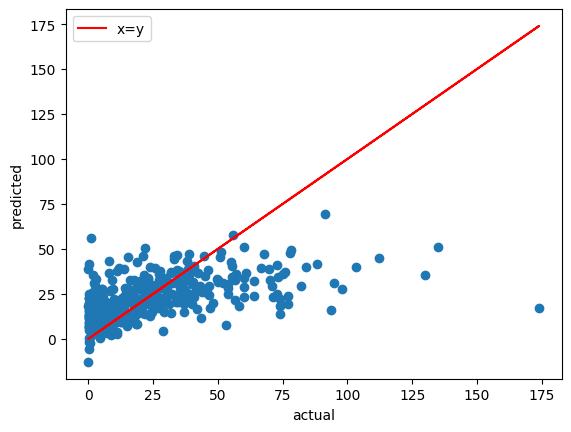

In [27]:
import matplotlib.pyplot as plt

# inverse transform
y_test = scaler_target.inverse_transform(y_test)
yhat = scaler_target.inverse_transform(yhat)

# Scores
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % np.sqrt(mse))
print('R_squared: %.3f' % r2)

plt.figure()
plt.scatter(y_test, yhat)
plt.plot(y_test, y_test, color = 'red', label = 'x=y')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend()
plt.show()

Naja, nicht ganz perfekt :-) Vor allem die höheren Werte scheinen schwieriger vorherzusagen zu sein. Das liegt daran, dass diese auch im Trainingsdatensatz seltener vorkommen (ein bekanntes Problem, was als "imbalanced regression/classification" bezeichnet wird). Außerdem werden offensichtlich Werte kleiner Null vorhergesagt, was für eine Konzentration ja nicht sinnvoll ist. Auch hier gibt es jedoch Techniken, dies zu vermeiden, indem man z.B. ReLu auch als Aktivierungsfunktion für das Output-Neuron verwendet.

Eine weitere Optimierung könnte man durch folgende Punkte erreichen:

* Die Aquiferkennzahl ist eigentlich eine kategorische Variable, wurde bisher aber ordinal encodiert. Hier könnte man ein One-Hot- oder Target-Encoding testen.
* Vermutlich korrelieren einige der Input-Variablen recht stark miteinander. Durch eine vorgeschaltete PCA könnten sich die Vorhersagen ebenfalls verbessern.
* Die Hyperparameter könnten noch besser optimiert werden, d.h. mehr Optionen für die bereits getesteten Hyperparameter oder weitere wie die Aktivierungsfunktion, Initialisierung und Lernrate.
* Man könnte die Anzahl der Neuronen und die Anzahl der Schichten verändern.

## Übungsaufgabe 1

Verändern Sie die Anzahl der Neuronen in der verdeckten Schicht! Sie können dies ebenfalls mit einer GridSearchCV machen, in dem Sie einen Parameter "neurons" im dictionary param_grid (s.o.) definieren und für diesen verschiedene Anzahlen als Optionen vorgeben. Damit die GridSearch nicht zu lange dauert, sollten sie die anderen Optimierungsparameter dafür rausnehmen, d.h. mit der besten HP-Kombination von oben arbeiten und nur noch die Anzahl der Neuronen optimieren. Experimentieren Sie außerdem noch mit einer zweiten verdeckten Schicht und optimieren Sie in dieser ebenfalls die Anzahl der Neuronen.
**Achtung:** Bei der Definition des baseline_model müssen sie für Parameter, die später über das param_dict definiert werden, einen Anfangswert eingeben!

In [28]:
import scikeras
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def baseline_model(optimizer='adam', neurons=5):
   
    # define model
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data

# ...

## Übungsaufgabe 2

Da sich mit einer veränderten Zahl der Neuronen und/oder Schichten wiederum andere Hyperparameter, vor allem die Anzahl der Epochen und der Batch-Size als günstiger erweisen könnten, ist es am besten, möglichst viele Hyperparameter gleichzeitig zu optimieren. Hier stößt die GridSearchCV aber schnell an ihre Grenzen. Eine weitere Alternative ist die [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), bei der eine definierte Anzahl an zufällig gewählten Kombination aus dem vorgegebenen Parameter-Space getestet werden. Hierbei ist zwar nicht garantiert, dass die absolut beste Kombination gefunden wird, jedoch liefert es meistens bei einem geringeren Rechenaufwand schon ganz brauchbare Hinweise, welche Kombinationen gut funktionieren und welche nicht.

**Achtung:** beim Befehl RandomizedSearchCV wird der Parameter "param_grid" durch "param_distributions" ersetzt. Ansonsten ist die Verwendung exakt gleich wie bei GridSearchCV. Als weitere Option kann man die Anzahl der Iterationen über "n_iter" festelegen. Default-Wert ist 10. Weiter Informationen finden sich auch in der Hilfe: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Optimieren Sie nun mehrere Hyperparameter gleichzeitig! Für den optimizer können Sie z.B. zusätzlich die Optionen 'Adagrad', 'Adadelta', 'Adamax' und 'Nadam' testen. Für die Aktivierungsfunktion kommen z.B. 'softmax', 'softplus', 'softsign', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear' in Frage und für die Initialisierung 'uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'. Je mehr Parameter und Optionen Sie gleichzeitig verwenden, desto höher sollten Sie den Wert für n_iter setzen, damit eine vernünftige Anzahl der möglichen Kombinationen ausprobiert wird. Als Daumenwert sollte dies mindestens etwa 0,1 * die Anzahl aller möglichen Kombinationen sein!

In [ ]:
import scikeras
# import packages
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def baseline_model(optimizer='adam', neurons=5, activation='relu'):
   
    # define model
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# import, split and scale data
# ...


grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring='neg_mean_squared_error', n_iter=50)

# ...

Wenn Sie eine bessere Parameterkombination als in der Vorlesung verwendet finden, so schreiben Sie den Algorithmus zur Vorhersage der Test-Daten mit dem besten Modell entsprechend um und sagen Sie dann mit diesem wiederum die Test-Daten voraus. Wie haben sich hier die Ergebnisse verändert?

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 3

Wenden Sie die gelernten Methoden des Kfold Crossvalidation und der Hyperparameter-Optimierung auch auf die Binär-Klassifikation an und schauen Sie, ob Sie die Performance des Random Forest aus Termin 3 übertreffen können.

In [ ]:
# ...

In [ ]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 4

Wenden Sie nun die hier gelernten Methoden zur Regression mit einem MLP auf den Beton-Datensatz aus Termin 3 (Concrete_Data.csv) an! Wie sind die Ergebnisse, die Sie erzielen können im Vergleich zum in Termin 3 angewandten Random-Forest Methode?

In [28]:
# ...

In [29]:
# Use optimized model for prediction of test data

# ...

## Übungsaufgabe 5 (optional, daher keine Lösung)

Testen Sie, ob Sie für den Grundwasserqualitätsdatensatz die Vorhersage von Nitrat verbessern können, wenn Sie eine PCA vorschalten und/oder den Aquifer anders codieren!